# Correlation Analysis:

Our aim with this notebook is to verify if there is a correlation between soccer players statistics and FIFA features

Primeiro eu vou ter que modelar temporalmente as bases de dados, por release e por jogos. A correlação pode ser posterior. Exemplo: O período X de estatísticas infere no período X+1 de atualizações do FIFA  

In [1]:
import math
import statistics

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from datetime import datetime
from scipy.stats.stats import pearsonr, spearmanr

In [2]:
df_fb = pd.read_table("Datasets/fbref2014.txt", sep='\t')
df_fifa = pd.read_table("Datasets/soFIFA.txt", sep='\t')
df_sentiment = pd.read_table("Datasets/comments_player.txt", sep='\t')
df_temporal_sentiment = pd.read_table("Datasets/sentiment_month.txt", sep='\t')
df_comments = pd.read_table("Datasets/amount_comments.txt", sep='\t')

In [3]:
df_fb.drop_duplicates(subset=['Name', 'Date'], keep ='first', inplace=True)
df_temporal_sentiment.drop_duplicates(subset=['Player ID', 'Year', 'Month', 'Sentiment'],
                                      keep ='first', inplace=True)
df_sentiment.dropna(axis=0, how='any', inplace=True)

In [4]:
def goals_taken(result):


    if '-' not in result:
        
        if 'W' in result:
            return 0
        else:
            return int(result.split(' ')[1])
        
    if 'W' in result:
        result = result.replace('W ', '').replace('-', ' ')
    elif 'L' in result:
        result = result.replace('L ', '').replace('-', ' ')
    elif 'D' in result:
        result = result.replace('D ', '').replace('-', ' ')
    else:
        return 0

    result = result.split(' ')
    if int(result[0]) > int(result[1]):
        return int(result[0])
    else:
        return int(result[1])

In [5]:
def join_parse_date(year, month):
    
    return datetime.strptime(str(month) + '/' + str(year), '%m/%Y')

In [6]:
def parse_date(date, flag=True):
    ''' 
        Will come in the format yyyy-mm-dd and will
        be transformed to mm/dd/yyyy
    '''
    if flag and '/' not in date:
        date_aux = date.split('-')
        date = date_aux[1] + '/' + date_aux[2] + '/' + date_aux[0]

    return datetime.strptime(date, '%m/%d/%Y')

df_fb['Goals Taken'] = list(map(lambda x: goals_taken(x), df_fb['Result']))
df_fb['Date'] = list(map(lambda x: parse_date(x), df_fb['Date']))
df_fifa['Release Date'] = list(map(lambda x: parse_date(x), df_fifa['Release Date']))
df_sentiment['Date'] = list(map(lambda x: parse_date(x), df_sentiment['Date']))

In [7]:
date_values = list(map(lambda x: x.split('/'), df_comments['Date']))
df_comments['Date'] = list(map(lambda x: join_parse_date(x[1], x[0]), date_values))

In [8]:
def make_backup(file_name, data):

    with open(file_name, 'w') as file:
        header = ['Player ID', 'Year', 'Month', 'Sentiment']
        file.write('\t'.join(header)+'\n')
        for player in data:
            for row in player:
                file.write('\t'.join(row)+'\n')

In [9]:
def comments_amount(df_x):
    
    df = df_x.copy()
    df_out = pd.DataFrame(columns = ['Name', 'Date', 'Comments'])
    df.set_index('Date',inplace=True)

    values = []
    for player in set(df['Name']):

        months = df.index.month
        
        for month in set(months):
            years = df.index.year
            comments = []
            df_out = pd.DataFrame(columns = ['Name', 'Date', 'Comments'])
            for year in set(years):
                amount_comments = len(df.loc[
                                        (df['Name'] == player) & 
                                        (df.index.month == month) & 
                                        (df.index.year == year)])
                comments.append(amount_comments)
            
            df_out['Name'] = [player for value in comments]
            df_out['Date'] = [str(month) +'/'+ str(year_x) for year_x in set(years)]
            df_out['Comments'] = comments
            values.append(df_out)

    return pd.concat(values)

# players = set(df_fifa['Name'])
# players = {float(df_fifa.loc[df_fifa['Name'] == player]['Id'].values[0]): player for player in players}
# df_sentiment = df_sentiment.replace({"Player Id": players})
# df_sentiment = df_sentiment.rename({'Player Id': 'Name'}, axis=1)
# df_comments = comments_amount(df_sentiment)
# df_comments.to_csv("teste_comments.txt", sep='\t', index=False)

In [10]:
def aggregate_by_month(df_sentiment):

    players = set(df_sentiment['Player Id'])
    players_sentiment = []
    for player in players:
        df_player = df_sentiment.loc[df_sentiment['Player Id'] == player]
        df_player.set_index('Date',inplace=True)
        years = df_player.index.year
        player_list = []
        for year in years:
            player_info = {}
            df_year = df_player.loc[df_player.index.year == year]
            months = df_year.index.month
            monthly_avg = df_year.groupby(months).Comment.mean()
            for month, sentiment in zip(monthly_avg.index,monthly_avg):
                player_list.append([str(player), str(year), str(month), str(sentiment)])
            #player_info = {player: {year: {month: sentiment 
                                           #for month, sentiment in zip(monthly_avg.index,monthly_avg)}}}
        players_sentiment.append(player_list)

    return players_sentiment

In [11]:
def replace_id_name(df_fifa, df_two):

    players = set(df_fifa['Name'])
    players = {df_fifa.loc[df_fifa['Name'] == player]['Id'].values[0]: player for player in players}
    df_two = df_two.replace({"Player ID": players})
    df_two = df_two.rename({'Player ID': 'Name'}, axis=1)
    df_two['Date'] = list(map(lambda x, y: join_parse_date(x, y), df_two['Year'], df_two['Month']))

    return df_two

In [12]:
df_temporal_sentiment = replace_id_name(df_fifa, df_temporal_sentiment)

In [ ]:
def _match_positions(df_fifa, df_two):

    release_dates = sorted(set(df_fifa['Release Date']))

    windows = []
    for date in range(1, len(release_dates)):

        window = df_two.loc[(df_two['Date'] >= release_dates[date-1]) &
                       (df_two['Date'] < release_dates[date])]
        
        windows.append({'Start': release_dates[date-1],
                        'End': release_dates[date], 
                        'Window': window})

    return windows


def correlation_analysis(df_fifa, df_two, fifa_column, two_column, corr_type = 'Pearson'):

    players_window = {}
    players = set(df_fifa['Name'])

    # This part will guarantee that the df_two will be represented by the same window
    for player in players:

        fifa_player = df_fifa.loc[df_fifa['Name'] == player]
        two_player = df_two.loc[df_two['Name'] == player]

        player_window = _match_positions(fifa_player, df_two)
        players_window[player] = player_window

    # Filling lists
    corr = {}
    for player in players:

        df_player = df_fifa.loc[df_fifa['Name'] == player]
        # Getting only the values in the release date
        feature_one, feature_two = [], []
        for date in players_window[player]:
            # I select only the feature of the release date, I put it temporally
            #df_release = df_player.loc[df_player['Release Date'] == date['Start']]
            # I will repeate this in way that the two arrays have the same size
            #sub = len(date['Window'][two_column])
            # This two arrays of features
            #feature_one += [df_release[fifa_column].values[0] for i in range(0, sub)]
            #feature_one += [df_release[fifa_column] for i in range(0, sub)]
            #feature_two += [max(date['Window'][two_column]) for i in range(0, len(date['Window'][two_column]))]
            # Testing another window
            df_release = df_player.loc[df_player['Release Date'] == date['End']]
            # This is the sum of the statistics column
            #print(len(date['Window'][two_column]))
            #sub = (date['Window'][two_column].describe()['mean'])
            #sub = date['Window'][two_column].describe()['max']
            #for value in date['Window']:
            #print(date['Window'][two_column].describe()['Comments'])
            
            sub = date['Window'][two_column].describe()['mean']
                #try:
                #    sub = sum(date['Window'][two_column])/sum(date['Window']['PK attempt'])
                #except:
                #   sub = 0
            feature_one.append(sub)
            feature_two.append(df_release[fifa_column].values[0])
        
        #feature_one = [x if not np.isnan(x) else 0 for x in feature_one]
        try:
            corr[player] = spearmanr(feature_one, feature_two)[0]
        except:
            corr[player] = 0
    
    return corr

In [ ]:
def corr_calc(df_fifa, df_two, values):
    
    df_list = []
    for fifa in values['FIFA']:
        for ref in values['Sentiment']:
            corr = correlation_analysis(df_fifa, df_two, fifa, ref)
            df = pd.DataFrame()
            df['Name'] = corr.keys()
            df['Correlation'] = corr.values()
            df['Feature One'] = [fifa for i in range(0, len(df['Name']))]
            df['Feature Two'] = [ref for i in range(0, len(df['Name']))]
            df_list.append(df)
        
    return pd.concat(df_list)

In [35]:
sentiment = {'FIFA': list(df_fifa.columns), 'Sentiment': ['Sentiment']}

attack = {'FIFA': ['Finishing', 'Shot Power', 'Volleys', 'Heading Accuracy', 'Long Shots'],
          'FBRef': ['Sh. On Target.', 'Shots', 'Goals']}

defense = {'FIFA': ['Sliding Tackle', 'Aggression', 'Strength', 'Marking'],
           'FBRef': ['Fouls Drawn', 'Fouls Commited', 'Yellow C.', 'Red C.', 'Interceptions', 'Tackles Won']}

goalkeeper = {'FIFA': ['GK Diving', 'GK Handling', 'GK Kicking', 'GK Positioning', 'GK Reflexes'], 
              'FBRef': ['Goals Taken']}

penalties = {'FIFA': ['Penalties'], 'FBRef': ['Pen. Kicks', 'PK attempt']}

crossing = {'FIFA': ['Short Passing', 'Long Passing', 'Vision', 'Crossing'],
            'FBRef': ['Assist.', 'Crosses']}

In [36]:
positions = list(set(df_fifa['Position']))
positions.append('All')

#corr_features = {'Attack': attack, 'Defense': defense,
                 #'Goalkeeper': goalkeeper, 'Penalties': penalties, 'Crossing': crossing}

corr_features = {'Sentiment': sentiment}
dataframes = []
for feat in corr_features:
    for position in positions:

        if position != 'All':
            fifa_player = df_fifa.loc[df_fifa['Position'] == position]
        else:
            fifa_player = df_fifa

        df_corr = corr_calc(fifa_player, df_temporal_sentiment, corr_features[feat])

        df_corr['Feature Set'] = [feat for i in range(0, len(df_corr))]
        df_corr['Position'] = [position for i in range(0, len(df_corr))]

        dataframes.append(df_corr)

df_out = pd.concat(dataframes)
df_out.to_csv("corr_comments_spearman_matrix.txt", sep='\t', index=False)

/usr/lib/python3.7/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


{'James Rodríguez': 0, 'Andrés Iniesta': nan, 'Oscar': nan}
{'James Rodríguez': 0, 'Andrés Iniesta': nan, 'Oscar': nan}


/usr/lib/python3.7/site-packages/scipy/stats/mstats_basic.py:477: RuntimeWarning: invalid value encountered in double_scalars
  rho /= ma.sqrt((denom-2*corr_x)*(denom-2*corr_y))


{'James Rodríguez': nan, 'Andrés Iniesta': nan, 'Oscar': nan}
{'James Rodríguez': nan, 'Andrés Iniesta': nan, 'Oscar': nan}
{'James Rodríguez': nan, 'Andrés Iniesta': nan, 'Oscar': nan}
{'James Rodríguez': 0, 'Andrés Iniesta': nan, 'Oscar': nan}
{'James Rodríguez': 0, 'Andrés Iniesta': nan, 'Oscar': nan}
{'James Rodríguez': 0, 'Andrés Iniesta': nan, 'Oscar': nan}
{'James Rodríguez': 0, 'Andrés Iniesta': nan, 'Oscar': nan}
{'James Rodríguez': 0, 'Andrés Iniesta': nan, 'Oscar': nan}
{'James Rodríguez': 0, 'Andrés Iniesta': nan, 'Oscar': nan}
{'James Rodríguez': nan, 'Andrés Iniesta': nan, 'Oscar': nan}
{'James Rodríguez': 0, 'Andrés Iniesta': nan, 'Oscar': nan}
{'James Rodríguez': 0, 'Andrés Iniesta': nan, 'Oscar': nan}
{'James Rodríguez': 0, 'Andrés Iniesta': nan, 'Oscar': nan}
{'James Rodríguez': nan, 'Andrés Iniesta': nan, 'Oscar': nan}
{'James Rodríguez': nan, 'Andrés Iniesta': nan, 'Oscar': nan}
{'James Rodríguez': nan, 'Andrés Iniesta': nan, 'Oscar': nan}
{'James Rodríguez': 0, 'An

{'Javier Mascherano': nan, 'Bastian Schweinsteiger': nan, 'Toni Kroos': nan}
{'Javier Mascherano': nan, 'Bastian Schweinsteiger': nan, 'Toni Kroos': nan}
{'Javier Mascherano': nan, 'Bastian Schweinsteiger': nan, 'Toni Kroos': nan}
{'Javier Mascherano': nan, 'Bastian Schweinsteiger': nan, 'Toni Kroos': nan}
{'Javier Mascherano': nan, 'Bastian Schweinsteiger': nan, 'Toni Kroos': nan}
{'Javier Mascherano': nan, 'Bastian Schweinsteiger': nan, 'Toni Kroos': nan}
{'Javier Mascherano': nan, 'Bastian Schweinsteiger': nan, 'Toni Kroos': nan}
{'Javier Mascherano': nan, 'Bastian Schweinsteiger': nan, 'Toni Kroos': nan}
{'Javier Mascherano': nan, 'Bastian Schweinsteiger': nan, 'Toni Kroos': nan}
{'Javier Mascherano': nan, 'Bastian Schweinsteiger': nan, 'Toni Kroos': nan}
{'Javier Mascherano': nan, 'Bastian Schweinsteiger': nan, 'Toni Kroos': nan}
{'Javier Mascherano': nan, 'Bastian Schweinsteiger': nan, 'Toni Kroos': nan}
{'Javier Mascherano': nan, 'Bastian Schweinsteiger': nan, 'Toni Kroos': nan}

/usr/lib/python3.7/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/lib/python3.7/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


{'Daniel Carvajal': nan, 'Dani Alves': 0, 'Pedro': 0}
{'Daniel Carvajal': nan, 'Dani Alves': 0, 'Pedro': 0}
{'Daniel Carvajal': nan, 'Dani Alves': nan, 'Pedro': nan}
{'Daniel Carvajal': -0.28068044571191997, 'Dani Alves': nan, 'Pedro': nan}
{'Daniel Carvajal': -0.10714285714285716, 'Dani Alves': nan, 'Pedro': nan}
{'Daniel Carvajal': -0.10714285714285716, 'Dani Alves': 0, 'Pedro': 0}
{'Daniel Carvajal': nan, 'Dani Alves': 0, 'Pedro': 0}
{'Daniel Carvajal': -0.18184824186332701, 'Dani Alves': 0, 'Pedro': 0}
{'Daniel Carvajal': 0.6123724356957945, 'Dani Alves': 0, 'Pedro': 0}
{'Daniel Carvajal': nan, 'Dani Alves': 0, 'Pedro': 0}
{'Daniel Carvajal': nan, 'Dani Alves': 0, 'Pedro': 0}
{'Daniel Carvajal': nan, 'Dani Alves': nan, 'Pedro': nan}
{'Daniel Carvajal': nan, 'Dani Alves': 0, 'Pedro': 0}
{'Daniel Carvajal': -0.21821789023599242, 'Dani Alves': 0, 'Pedro': 0}
{'Daniel Carvajal': nan, 'Dani Alves': 0, 'Pedro': 0}
{'Daniel Carvajal': -0.2886751345948129, 'Dani Alves': nan, 'Pedro': nan}


{'Javier Mascherano': nan, 'Bastian Schweinsteiger': 0, 'David Luiz': nan}
{'Javier Mascherano': nan, 'Bastian Schweinsteiger': 0, 'David Luiz': nan}
{'Javier Mascherano': nan, 'Bastian Schweinsteiger': 0, 'David Luiz': nan}
{'Javier Mascherano': nan, 'Bastian Schweinsteiger': 0, 'David Luiz': nan}
{'Javier Mascherano': nan, 'Bastian Schweinsteiger': 0, 'David Luiz': nan}
{'Javier Mascherano': nan, 'Bastian Schweinsteiger': 0, 'David Luiz': nan}
{'Javier Mascherano': nan, 'Bastian Schweinsteiger': 0, 'David Luiz': nan}
{'Javier Mascherano': nan, 'Bastian Schweinsteiger': 0, 'David Luiz': nan}
{'Javier Mascherano': nan, 'Bastian Schweinsteiger': 0, 'David Luiz': nan}
{'Javier Mascherano': nan, 'Bastian Schweinsteiger': 0, 'David Luiz': nan}
{'Javier Mascherano': nan, 'Bastian Schweinsteiger': 0, 'David Luiz': nan}
{'Javier Mascherano': nan, 'Bastian Schweinsteiger': 0, 'David Luiz': nan}
{'Javier Mascherano': nan, 'Bastian Schweinsteiger': 0, 'David Luiz': nan}
{'Javier Mascherano': nan

{'Wayne Rooney': 0, 'Karim Benzema': 0, 'Álvaro Morata': 0.7758098206022831, 'Gonzalo Higuaín': 0, 'Javier Hernández': 0, 'David Villa': 0, 'Fernando Torres': 0, 'Mohamed Salah': 0, 'Zlatan Ibrahimovic': 0, 'Cristiano Ronaldo': 0, 'Sergio Agüero': 0, 'Radamel Falcao': nan, 'Gareth Bale': 0, 'Luis Suárez': nan, 'Mario Balotelli': 0, 'Mario Götze': 0}
{'Wayne Rooney': 0, 'Karim Benzema': 0, 'Álvaro Morata': 0.2032404582259038, 'Gonzalo Higuaín': 0, 'Javier Hernández': 0, 'David Villa': 0, 'Fernando Torres': 0, 'Mohamed Salah': 0, 'Zlatan Ibrahimovic': 0, 'Cristiano Ronaldo': 0, 'Sergio Agüero': 0, 'Radamel Falcao': -0.2927700218845599, 'Gareth Bale': 0, 'Luis Suárez': nan, 'Mario Balotelli': 0, 'Mario Götze': 0}
{'Wayne Rooney': nan, 'Karim Benzema': nan, 'Álvaro Morata': 0.3178208630818641, 'Gonzalo Higuaín': nan, 'Javier Hernández': nan, 'David Villa': nan, 'Fernando Torres': 0, 'Mohamed Salah': nan, 'Zlatan Ibrahimovic': nan, 'Cristiano Ronaldo': 0, 'Sergio Agüero': nan, 'Radamel Falc

{'Wayne Rooney': nan, 'Karim Benzema': nan, 'Álvaro Morata': -0.3881915000262637, 'Gonzalo Higuaín': nan, 'Javier Hernández': nan, 'David Villa': nan, 'Fernando Torres': 0, 'Mohamed Salah': nan, 'Zlatan Ibrahimovic': nan, 'Cristiano Ronaldo': 0, 'Sergio Agüero': nan, 'Radamel Falcao': 0.13093073414159545, 'Gareth Bale': nan, 'Luis Suárez': 0.9486832980505139, 'Mario Balotelli': nan, 'Mario Götze': nan}
{'Wayne Rooney': nan, 'Karim Benzema': nan, 'Álvaro Morata': -0.30444180048452957, 'Gonzalo Higuaín': nan, 'Javier Hernández': nan, 'David Villa': nan, 'Fernando Torres': 0, 'Mohamed Salah': nan, 'Zlatan Ibrahimovic': nan, 'Cristiano Ronaldo': 0, 'Sergio Agüero': nan, 'Radamel Falcao': 0.6210590034081188, 'Gareth Bale': nan, 'Luis Suárez': 0.9486832980505139, 'Mario Balotelli': nan, 'Mario Götze': nan}
{'Wayne Rooney': nan, 'Karim Benzema': nan, 'Álvaro Morata': -0.4785984984029348, 'Gonzalo Higuaín': nan, 'Javier Hernández': nan, 'David Villa': nan, 'Fernando Torres': 0, 'Mohamed Salah'

{'Wayne Rooney': nan, 'Karim Benzema': nan, 'Álvaro Morata': 0.5222329678670935, 'Gonzalo Higuaín': nan, 'Javier Hernández': nan, 'David Villa': nan, 'Fernando Torres': 0, 'Mohamed Salah': nan, 'Zlatan Ibrahimovic': nan, 'Cristiano Ronaldo': 0, 'Sergio Agüero': nan, 'Radamel Falcao': nan, 'Gareth Bale': nan, 'Luis Suárez': nan, 'Mario Balotelli': nan, 'Mario Götze': nan}
{'Wayne Rooney': 0, 'Karim Benzema': 0, 'Álvaro Morata': nan, 'Gonzalo Higuaín': 0, 'Javier Hernández': 0, 'David Villa': 0, 'Fernando Torres': 0, 'Mohamed Salah': 0, 'Zlatan Ibrahimovic': 0, 'Cristiano Ronaldo': 0, 'Sergio Agüero': 0, 'Radamel Falcao': -0.5408987230262506, 'Gareth Bale': 0, 'Luis Suárez': -0.9486832980505139, 'Mario Balotelli': 0, 'Mario Götze': 0}
{'Wayne Rooney': 0, 'Karim Benzema': 0, 'Álvaro Morata': -0.7146196756975327, 'Gonzalo Higuaín': 0, 'Javier Hernández': 0, 'David Villa': 0, 'Fernando Torres': 0, 'Mohamed Salah': 0, 'Zlatan Ibrahimovic': 0, 'Cristiano Ronaldo': 0, 'Sergio Agüero': 0, 'Rada

{'Andrés Iniesta': nan, 'David Villa': nan, 'Cristiano Ronaldo': nan, 'Neymar': nan, 'Isco': nan}
{'Andrés Iniesta': nan, 'David Villa': nan, 'Cristiano Ronaldo': nan, 'Neymar': nan, 'Isco': 0.35355339059327373}
{'Andrés Iniesta': nan, 'David Villa': nan, 'Cristiano Ronaldo': nan, 'Neymar': nan, 'Isco': nan}
{'Andrés Iniesta': nan, 'David Villa': nan, 'Cristiano Ronaldo': nan, 'Neymar': nan, 'Isco': nan}
{'Andrés Iniesta': nan, 'David Villa': nan, 'Cristiano Ronaldo': nan, 'Neymar': nan, 'Isco': nan}
{'Andrés Iniesta': nan, 'David Villa': nan, 'Cristiano Ronaldo': nan, 'Neymar': nan, 'Isco': nan}
{'Andrés Iniesta': nan, 'David Villa': nan, 'Cristiano Ronaldo': nan, 'Neymar': nan, 'Isco': nan}
{'Andrés Iniesta': nan, 'David Villa': nan, 'Cristiano Ronaldo': nan, 'Neymar': nan, 'Isco': nan}
{'Andrés Iniesta': nan, 'David Villa': nan, 'Cristiano Ronaldo': nan, 'Neymar': nan, 'Isco': nan}
{'Andrés Iniesta': nan, 'David Villa': nan, 'Cristiano Ronaldo': nan, 'Neymar': 0, 'Isco': -0.11180339

{'Mohamed Salah': nan, 'Mesut Özil': 0, 'Juan Mata': nan, 'Gareth Bale': nan, 'David Silva': nan, 'Oscar': nan, 'Juan Cuadrado': -0.7745966692414834, 'Thomas Müller': nan}
{'Mohamed Salah': nan, 'Mesut Özil': 0, 'Juan Mata': nan, 'Gareth Bale': nan, 'David Silva': nan, 'Oscar': nan, 'Juan Cuadrado': 0.7745966692414834, 'Thomas Müller': nan}
{'Mohamed Salah': nan, 'Mesut Özil': 0, 'Juan Mata': nan, 'Gareth Bale': nan, 'David Silva': nan, 'Oscar': nan, 'Juan Cuadrado': 0.632455532033676, 'Thomas Müller': nan}
{'Mohamed Salah': nan, 'Mesut Özil': 0, 'Juan Mata': nan, 'Gareth Bale': nan, 'David Silva': nan, 'Oscar': nan, 'Juan Cuadrado': 0.632455532033676, 'Thomas Müller': nan}
{'Mohamed Salah': nan, 'Mesut Özil': 0, 'Juan Mata': nan, 'Gareth Bale': nan, 'David Silva': nan, 'Oscar': nan, 'Juan Cuadrado': 0.7745966692414834, 'Thomas Müller': nan}
{'Mohamed Salah': nan, 'Mesut Özil': 0, 'Juan Mata': nan, 'Gareth Bale': nan, 'David Silva': nan, 'Oscar': nan, 'Juan Cuadrado': 0.774596669241483

{'Zlatan Ibrahimovic': nan, 'Gonzalo Higuaín': nan, 'Luis Suárez': nan}
{'Zlatan Ibrahimovic': nan, 'Gonzalo Higuaín': nan, 'Luis Suárez': nan}
{'Zlatan Ibrahimovic': nan, 'Gonzalo Higuaín': nan, 'Luis Suárez': nan}
{'Zlatan Ibrahimovic': nan, 'Gonzalo Higuaín': nan, 'Luis Suárez': nan}
{'Zlatan Ibrahimovic': nan, 'Gonzalo Higuaín': nan, 'Luis Suárez': nan}
{'Zlatan Ibrahimovic': nan, 'Gonzalo Higuaín': nan, 'Luis Suárez': nan}
{'Zlatan Ibrahimovic': nan, 'Gonzalo Higuaín': nan, 'Luis Suárez': nan}
{'Zlatan Ibrahimovic': nan, 'Gonzalo Higuaín': nan, 'Luis Suárez': nan}
{'Zlatan Ibrahimovic': nan, 'Gonzalo Higuaín': nan, 'Luis Suárez': nan}
{'Zlatan Ibrahimovic': nan, 'Gonzalo Higuaín': nan, 'Luis Suárez': nan}
{'Zlatan Ibrahimovic': nan, 'Gonzalo Higuaín': nan, 'Luis Suárez': nan}
{'Zlatan Ibrahimovic': nan, 'Gonzalo Higuaín': nan, 'Luis Suárez': nan}
{'Zlatan Ibrahimovic': nan, 'Gonzalo Higuaín': nan, 'Luis Suárez': nan}
{'Zlatan Ibrahimovic': nan, 'Gonzalo Higuaín': nan, 'Luis Suárez

{'Eden Hazard': nan, 'Andrés Iniesta': nan, 'Gareth Bale': nan}
{'Eden Hazard': nan, 'Andrés Iniesta': nan, 'Gareth Bale': nan}
{'Eden Hazard': nan, 'Andrés Iniesta': nan, 'Gareth Bale': nan}
{'Eden Hazard': nan, 'Andrés Iniesta': nan, 'Gareth Bale': nan}
{'Eden Hazard': nan, 'Andrés Iniesta': nan, 'Gareth Bale': nan}
{'Eden Hazard': nan, 'Andrés Iniesta': nan, 'Gareth Bale': nan}
{'Eden Hazard': nan, 'Andrés Iniesta': nan, 'Gareth Bale': nan}
{'Eden Hazard': nan, 'Andrés Iniesta': nan, 'Gareth Bale': nan}
{'Eden Hazard': nan, 'Andrés Iniesta': nan, 'Gareth Bale': nan}
{'Eden Hazard': nan, 'Andrés Iniesta': nan, 'Gareth Bale': nan}
{'Eden Hazard': nan, 'Andrés Iniesta': nan, 'Gareth Bale': nan}
{'Eden Hazard': 0, 'Andrés Iniesta': nan, 'Gareth Bale': 0}
{'Eden Hazard': 0, 'Andrés Iniesta': nan, 'Gareth Bale': 0}
{'Eden Hazard': nan, 'Andrés Iniesta': nan, 'Gareth Bale': nan}
{'Eden Hazard': nan, 'Andrés Iniesta': nan, 'Gareth Bale': nan}
{'Eden Hazard': 0, 'Andrés Iniesta': nan, 'Garet

{'Bastian Schweinsteiger': 0, 'David Luiz': nan, 'Gerard Piqué': 0, 'Raphaël Varane': 0, 'Sergio Ramos': nan}
{'Bastian Schweinsteiger': 0, 'David Luiz': nan, 'Gerard Piqué': 0, 'Raphaël Varane': 0, 'Sergio Ramos': nan}
{'Bastian Schweinsteiger': 0, 'David Luiz': nan, 'Gerard Piqué': 0, 'Raphaël Varane': 0, 'Sergio Ramos': nan}
{'Bastian Schweinsteiger': 0, 'David Luiz': nan, 'Gerard Piqué': 0, 'Raphaël Varane': 0, 'Sergio Ramos': nan}
{'Bastian Schweinsteiger': nan, 'David Luiz': -0.9999999999999999, 'Gerard Piqué': nan, 'Raphaël Varane': nan, 'Sergio Ramos': nan}
{'Bastian Schweinsteiger': nan, 'David Luiz': -0.9999999999999999, 'Gerard Piqué': nan, 'Raphaël Varane': nan, 'Sergio Ramos': nan}
{'Bastian Schweinsteiger': nan, 'David Luiz': nan, 'Gerard Piqué': nan, 'Raphaël Varane': nan, 'Sergio Ramos': nan}
{'Bastian Schweinsteiger': nan, 'David Luiz': nan, 'Gerard Piqué': nan, 'Raphaël Varane': nan, 'Sergio Ramos': nan}
{'Bastian Schweinsteiger': nan, 'David Luiz': -0.999999999999999

{'Bastian Schweinsteiger': 0.5428571428571429, 'David De Gea': nan, 'Álvaro Morata': nan, 'David Luiz': nan, 'David Villa': nan, 'Javier Hernández': -0.9999999999999999, 'Fernando Torres': nan, 'Zlatan Ibrahimovic': -1.0, 'Ezequiel Lavezzi': nan, 'Isco': nan, 'Antoine Griezmann': nan, 'Wayne Rooney': 0, 'Gonzalo Higuaín': -0.8285714285714287, 'Sergio Agüero': -0.44545454545454555, 'Radamel Falcao': 0.48571428571428577, 'Mesut Özil': nan, 'Juan Mata': nan, 'Juan Cuadrado': nan, 'Mario Götze': nan, 'Manuel Neuer': nan, 'Jack Wilshere': -0.5714285714285715, 'Karim Benzema': -0.5, 'Pedro': -0.3571428571428572, 'Dani Alves': nan, 'Oscar': nan, 'Cesc Fàbregas': nan, 'Paul Pogba': nan, 'Andrés Iniesta': nan, 'Daniel Carvajal': nan, 'Raphaël Varane': nan, 'Arturo Vidal': nan, 'Marcelo': -0.9999999999999999, 'Mario Balotelli': nan, 'Thomas Müller': -1.0, 'Toni Kroos': nan}
{'Bastian Schweinsteiger': 0.5428571428571429, 'David De Gea': 0, 'Álvaro Morata': 0, 'David Luiz': 0, 'David Villa': nan, 

{'Bastian Schweinsteiger': nan, 'David De Gea': nan, 'Álvaro Morata': nan, 'David Luiz': nan, 'David Villa': nan, 'Javier Hernández': nan, 'Fernando Torres': nan, 'Zlatan Ibrahimovic': nan, 'Ezequiel Lavezzi': nan, 'Isco': nan, 'Antoine Griezmann': nan, 'Wayne Rooney': 0, 'Gonzalo Higuaín': -0.4140393356054126, 'Sergio Agüero': nan, 'Radamel Falcao': -0.6546536707079772, 'Mesut Özil': nan, 'Juan Mata': nan, 'Juan Cuadrado': nan, 'Mario Götze': nan, 'Manuel Neuer': nan, 'Jack Wilshere': nan, 'Karim Benzema': nan, 'Pedro': -0.2886751345948129, 'Dani Alves': nan, 'Oscar': nan, 'Cesc Fàbregas': nan, 'Paul Pogba': nan, 'Andrés Iniesta': nan, 'Daniel Carvajal': nan, 'Raphaël Varane': nan, 'Arturo Vidal': nan, 'Marcelo': nan, 'Mario Balotelli': nan, 'Thomas Müller': nan, 'Toni Kroos': nan}
{'Bastian Schweinsteiger': nan, 'David De Gea': nan, 'Álvaro Morata': nan, 'David Luiz': nan, 'David Villa': nan, 'Javier Hernández': nan, 'Fernando Torres': nan, 'Zlatan Ibrahimovic': nan, 'Ezequiel Lavezz

{'Bastian Schweinsteiger': 0.8280786712108252, 'David De Gea': 0, 'Álvaro Morata': 0, 'David Luiz': 0, 'David Villa': nan, 'Javier Hernández': nan, 'Fernando Torres': 0, 'Zlatan Ibrahimovic': nan, 'Ezequiel Lavezzi': 0, 'Isco': 0, 'Antoine Griezmann': nan, 'Wayne Rooney': 0, 'Gonzalo Higuaín': -0.6761234037828133, 'Sergio Agüero': 0.49702673280471504, 'Radamel Falcao': -0.09759000729485333, 'Mesut Özil': nan, 'Juan Mata': 0, 'Juan Cuadrado': nan, 'Mario Götze': 0, 'Manuel Neuer': nan, 'Jack Wilshere': nan, 'Karim Benzema': 0.0, 'Pedro': 0.6123724356957945, 'Dani Alves': 0, 'Oscar': 0, 'Cesc Fàbregas': 0, 'Paul Pogba': nan, 'Andrés Iniesta': nan, 'Daniel Carvajal': 0, 'Raphaël Varane': nan, 'Arturo Vidal': nan, 'Marcelo': -0.9999999999999999, 'Mario Balotelli': 0, 'Thomas Müller': -0.8660254037844387, 'Toni Kroos': nan}
{'Bastian Schweinsteiger': -0.8280786712108252, 'David De Gea': 0, 'Álvaro Morata': 0, 'David Luiz': 0, 'David Villa': nan, 'Javier Hernández': nan, 'Fernando Torres': 0

{'Bastian Schweinsteiger': nan, 'David De Gea': nan, 'Álvaro Morata': nan, 'David Luiz': nan, 'David Villa': nan, 'Javier Hernández': nan, 'Fernando Torres': nan, 'Zlatan Ibrahimovic': nan, 'Ezequiel Lavezzi': nan, 'Isco': nan, 'Antoine Griezmann': nan, 'Wayne Rooney': 0, 'Gonzalo Higuaín': -0.6789347398332045, 'Sergio Agüero': nan, 'Radamel Falcao': nan, 'Mesut Özil': nan, 'Juan Mata': nan, 'Juan Cuadrado': nan, 'Mario Götze': nan, 'Manuel Neuer': nan, 'Jack Wilshere': 0.6546536707079771, 'Karim Benzema': nan, 'Pedro': -0.38546712656253507, 'Dani Alves': nan, 'Oscar': nan, 'Cesc Fàbregas': nan, 'Paul Pogba': nan, 'Andrés Iniesta': nan, 'Daniel Carvajal': nan, 'Raphaël Varane': nan, 'Arturo Vidal': nan, 'Marcelo': nan, 'Mario Balotelli': nan, 'Thomas Müller': nan, 'Toni Kroos': nan}
{'Bastian Schweinsteiger': nan, 'David De Gea': nan, 'Álvaro Morata': nan, 'David Luiz': nan, 'David Villa': nan, 'Javier Hernández': nan, 'Fernando Torres': nan, 'Zlatan Ibrahimovic': nan, 'Ezequiel Lavezz

{'Bastian Schweinsteiger': -0.8280786712108252, 'David De Gea': nan, 'Álvaro Morata': nan, 'David Luiz': nan, 'David Villa': nan, 'Javier Hernández': nan, 'Fernando Torres': nan, 'Zlatan Ibrahimovic': 0.7745966692414834, 'Ezequiel Lavezzi': nan, 'Isco': nan, 'Antoine Griezmann': nan, 'Wayne Rooney': 0, 'Gonzalo Higuaín': -0.7356123579206245, 'Sergio Agüero': -0.40321056270364186, 'Radamel Falcao': nan, 'Mesut Özil': nan, 'Juan Mata': nan, 'Juan Cuadrado': nan, 'Mario Götze': nan, 'Manuel Neuer': nan, 'Jack Wilshere': 0.6546536707079771, 'Karim Benzema': nan, 'Pedro': -0.13944333775567924, 'Dani Alves': nan, 'Oscar': nan, 'Cesc Fàbregas': nan, 'Paul Pogba': nan, 'Andrés Iniesta': nan, 'Daniel Carvajal': nan, 'Raphaël Varane': nan, 'Arturo Vidal': nan, 'Marcelo': nan, 'Mario Balotelli': nan, 'Thomas Müller': nan, 'Toni Kroos': nan}
{'Bastian Schweinsteiger': -0.4780914437337575, 'David De Gea': nan, 'Álvaro Morata': nan, 'David Luiz': nan, 'David Villa': nan, 'Javier Hernández': nan, 'Fe

{'Bastian Schweinsteiger': -0.8280786712108252, 'David De Gea': nan, 'Álvaro Morata': nan, 'David Luiz': nan, 'David Villa': nan, 'Javier Hernández': nan, 'Fernando Torres': nan, 'Zlatan Ibrahimovic': nan, 'Ezequiel Lavezzi': nan, 'Isco': nan, 'Antoine Griezmann': nan, 'Wayne Rooney': 0, 'Gonzalo Higuaín': -0.4140393356054126, 'Sergio Agüero': nan, 'Radamel Falcao': nan, 'Mesut Özil': nan, 'Juan Mata': nan, 'Juan Cuadrado': nan, 'Mario Götze': nan, 'Manuel Neuer': nan, 'Jack Wilshere': -0.7824607964359516, 'Karim Benzema': nan, 'Pedro': -0.38546712656253507, 'Dani Alves': nan, 'Oscar': nan, 'Cesc Fàbregas': nan, 'Paul Pogba': nan, 'Andrés Iniesta': nan, 'Daniel Carvajal': nan, 'Raphaël Varane': nan, 'Arturo Vidal': nan, 'Marcelo': nan, 'Mario Balotelli': nan, 'Thomas Müller': -0.8660254037844387, 'Toni Kroos': nan}
{'Bastian Schweinsteiger': -0.8280786712108252, 'David De Gea': nan, 'Álvaro Morata': nan, 'David Luiz': nan, 'David Villa': nan, 'Javier Hernández': nan, 'Fernando Torres':

{'Bastian Schweinsteiger': nan, 'David De Gea': 0, 'Álvaro Morata': 0, 'David Luiz': 0, 'David Villa': nan, 'Javier Hernández': nan, 'Fernando Torres': 0, 'Zlatan Ibrahimovic': nan, 'Ezequiel Lavezzi': 0, 'Isco': 0, 'Antoine Griezmann': nan, 'Wayne Rooney': 0, 'Gonzalo Higuaín': nan, 'Sergio Agüero': nan, 'Radamel Falcao': nan, 'Mesut Özil': nan, 'Juan Mata': 0, 'Juan Cuadrado': nan, 'Mario Götze': 0, 'Manuel Neuer': nan, 'Jack Wilshere': nan, 'Karim Benzema': nan, 'Pedro': nan, 'Dani Alves': 0, 'Oscar': 0, 'Cesc Fàbregas': 0, 'Paul Pogba': nan, 'Andrés Iniesta': nan, 'Daniel Carvajal': 0, 'Raphaël Varane': nan, 'Arturo Vidal': nan, 'Marcelo': nan, 'Mario Balotelli': 0, 'Thomas Müller': nan, 'Toni Kroos': nan}
{'Bastian Schweinsteiger': nan, 'David De Gea': 0, 'Álvaro Morata': 0, 'David Luiz': 0, 'David Villa': nan, 'Javier Hernández': nan, 'Fernando Torres': 0, 'Zlatan Ibrahimovic': nan, 'Ezequiel Lavezzi': 0, 'Isco': 0, 'Antoine Griezmann': nan, 'Wayne Rooney': 0, 'Gonzalo Higuaín': 

{'Antoine Griezmann': nan, 'Wayne Rooney': nan, 'Andrés Iniesta': nan, 'Bastian Schweinsteiger': nan, 'Jack Wilshere': 0.9999999999999999, 'Arturo Vidal': nan, 'Sergio Agüero': nan, 'Mesut Özil': nan, 'Juan Mata': 0.632455532033676, 'Ezequiel Lavezzi': nan, 'David Silva': nan, 'Oscar': 0.5773502691896257, 'James Rodríguez': -0.3857583749052298, 'Toni Kroos': nan, 'Paul Pogba': nan}
{'Antoine Griezmann': nan, 'Wayne Rooney': nan, 'Andrés Iniesta': nan, 'Bastian Schweinsteiger': nan, 'Jack Wilshere': nan, 'Arturo Vidal': nan, 'Sergio Agüero': nan, 'Mesut Özil': nan, 'Juan Mata': nan, 'Ezequiel Lavezzi': nan, 'David Silva': nan, 'Oscar': nan, 'James Rodríguez': -0.3857583749052298, 'Toni Kroos': nan, 'Paul Pogba': nan}
{'Antoine Griezmann': nan, 'Wayne Rooney': nan, 'Andrés Iniesta': nan, 'Bastian Schweinsteiger': nan, 'Jack Wilshere': nan, 'Arturo Vidal': nan, 'Sergio Agüero': nan, 'Mesut Özil': nan, 'Juan Mata': 0.2581988897471611, 'Ezequiel Lavezzi': nan, 'David Silva': nan, 'Oscar': 0

{'Antoine Griezmann': nan, 'Wayne Rooney': nan, 'Andrés Iniesta': nan, 'Bastian Schweinsteiger': nan, 'Jack Wilshere': nan, 'Arturo Vidal': nan, 'Sergio Agüero': nan, 'Mesut Özil': nan, 'Juan Mata': nan, 'Ezequiel Lavezzi': nan, 'David Silva': nan, 'Oscar': nan, 'James Rodríguez': -0.2886751345948129, 'Toni Kroos': nan, 'Paul Pogba': nan}
{'Antoine Griezmann': nan, 'Wayne Rooney': nan, 'Andrés Iniesta': nan, 'Bastian Schweinsteiger': nan, 'Jack Wilshere': nan, 'Arturo Vidal': nan, 'Sergio Agüero': nan, 'Mesut Özil': nan, 'Juan Mata': 0.7745966692414834, 'Ezequiel Lavezzi': nan, 'David Silva': nan, 'Oscar': -0.5773502691896257, 'James Rodríguez': 0.6123724356957945, 'Toni Kroos': nan, 'Paul Pogba': nan}
{'Antoine Griezmann': nan, 'Wayne Rooney': nan, 'Andrés Iniesta': nan, 'Bastian Schweinsteiger': nan, 'Jack Wilshere': nan, 'Arturo Vidal': nan, 'Sergio Agüero': nan, 'Mesut Özil': nan, 'Juan Mata': 0.2581988897471611, 'Ezequiel Lavezzi': nan, 'David Silva': nan, 'Oscar': 0.5773502691896

{'Antoine Griezmann': 0, 'Wayne Rooney': 0, 'Andrés Iniesta': nan, 'Bastian Schweinsteiger': 0, 'Jack Wilshere': nan, 'Arturo Vidal': 0, 'Sergio Agüero': nan, 'Mesut Özil': 0, 'Juan Mata': nan, 'Ezequiel Lavezzi': nan, 'David Silva': 0, 'Oscar': nan, 'James Rodríguez': nan, 'Toni Kroos': 0, 'Paul Pogba': nan}
{'Antoine Griezmann': nan, 'Wayne Rooney': 0, 'Álvaro Morata': nan, 'David Villa': 0, 'Javier Hernández': nan, 'Fernando Torres': nan, 'Mohamed Salah': nan, 'Zlatan Ibrahimovic': nan, 'Cristiano Ronaldo': 0, 'Ezequiel Lavezzi': nan, 'Gareth Bale': 0, 'Luis Suárez': nan, 'Neymar': nan, 'Mario Balotelli': 0}
{'Antoine Griezmann': nan, 'Wayne Rooney': 0, 'Álvaro Morata': nan, 'David Villa': 0, 'Javier Hernández': nan, 'Fernando Torres': nan, 'Mohamed Salah': nan, 'Zlatan Ibrahimovic': nan, 'Cristiano Ronaldo': 0, 'Ezequiel Lavezzi': nan, 'Gareth Bale': 0, 'Luis Suárez': nan, 'Neymar': nan, 'Mario Balotelli': 0}
{'Antoine Griezmann': nan, 'Wayne Rooney': nan, 'Álvaro Morata': nan, 'Da

{'Antoine Griezmann': nan, 'Wayne Rooney': 0, 'Álvaro Morata': nan, 'David Villa': 0, 'Javier Hernández': nan, 'Fernando Torres': nan, 'Mohamed Salah': nan, 'Zlatan Ibrahimovic': nan, 'Cristiano Ronaldo': 0, 'Ezequiel Lavezzi': nan, 'Gareth Bale': 0, 'Luis Suárez': nan, 'Neymar': nan, 'Mario Balotelli': 0}
{'Antoine Griezmann': nan, 'Wayne Rooney': 0, 'Álvaro Morata': nan, 'David Villa': 0, 'Javier Hernández': nan, 'Fernando Torres': nan, 'Mohamed Salah': nan, 'Zlatan Ibrahimovic': nan, 'Cristiano Ronaldo': 0, 'Ezequiel Lavezzi': nan, 'Gareth Bale': 0, 'Luis Suárez': nan, 'Neymar': nan, 'Mario Balotelli': 0}
{'Antoine Griezmann': nan, 'Wayne Rooney': 0, 'Álvaro Morata': nan, 'David Villa': 0, 'Javier Hernández': nan, 'Fernando Torres': nan, 'Mohamed Salah': nan, 'Zlatan Ibrahimovic': nan, 'Cristiano Ronaldo': 0, 'Ezequiel Lavezzi': nan, 'Gareth Bale': 0, 'Luis Suárez': nan, 'Neymar': nan, 'Mario Balotelli': 0}
{'Antoine Griezmann': nan, 'Wayne Rooney': nan, 'Álvaro Morata': nan, 'David

{'Antoine Griezmann': nan, 'Wayne Rooney': nan, 'Álvaro Morata': nan, 'David Villa': nan, 'Javier Hernández': nan, 'Fernando Torres': nan, 'Mohamed Salah': nan, 'Zlatan Ibrahimovic': nan, 'Cristiano Ronaldo': nan, 'Ezequiel Lavezzi': nan, 'Gareth Bale': 0, 'Luis Suárez': -0.8280786712108252, 'Neymar': nan, 'Mario Balotelli': 0}
{'Antoine Griezmann': nan, 'Wayne Rooney': nan, 'Álvaro Morata': nan, 'David Villa': nan, 'Javier Hernández': nan, 'Fernando Torres': nan, 'Mohamed Salah': nan, 'Zlatan Ibrahimovic': nan, 'Cristiano Ronaldo': nan, 'Ezequiel Lavezzi': nan, 'Gareth Bale': 0, 'Luis Suárez': nan, 'Neymar': nan, 'Mario Balotelli': 0}
{'Antoine Griezmann': nan, 'Wayne Rooney': nan, 'Álvaro Morata': nan, 'David Villa': nan, 'Javier Hernández': 0.8660254037844387, 'Fernando Torres': 0.76248369253472, 'Mohamed Salah': nan, 'Zlatan Ibrahimovic': nan, 'Cristiano Ronaldo': nan, 'Ezequiel Lavezzi': nan, 'Gareth Bale': 0, 'Luis Suárez': nan, 'Neymar': nan, 'Mario Balotelli': 0}
{'Antoine Grie

{'Antoine Griezmann': nan, 'Mohamed Salah': nan, 'Mesut Özil': nan, 'Eden Hazard': nan, 'David Silva': nan, 'James Rodríguez': nan, 'Isco': nan}
{'Antoine Griezmann': nan, 'Mohamed Salah': nan, 'Mesut Özil': nan, 'Eden Hazard': nan, 'David Silva': nan, 'James Rodríguez': nan, 'Isco': nan}
{'Antoine Griezmann': nan, 'Mohamed Salah': nan, 'Mesut Özil': nan, 'Eden Hazard': nan, 'David Silva': nan, 'James Rodríguez': nan, 'Isco': nan}
{'Antoine Griezmann': 0, 'Mohamed Salah': nan, 'Mesut Özil': nan, 'Eden Hazard': 0, 'David Silva': 0, 'James Rodríguez': nan, 'Isco': 0}
{'Antoine Griezmann': 0, 'Mohamed Salah': nan, 'Mesut Özil': nan, 'Eden Hazard': 0, 'David Silva': 0, 'James Rodríguez': nan, 'Isco': 0}
{'Antoine Griezmann': 0, 'Mohamed Salah': nan, 'Mesut Özil': nan, 'Eden Hazard': 0, 'David Silva': 0, 'James Rodríguez': nan, 'Isco': 0}
{'Antoine Griezmann': nan, 'Mohamed Salah': nan, 'Mesut Özil': nan, 'Eden Hazard': nan, 'David Silva': nan, 'James Rodríguez': nan, 'Isco': nan}
{'Antoine

{'Antoine Griezmann': nan, 'Pedro': nan, 'Mesut Özil': nan, 'David Silva': nan, 'Oscar': nan, 'Juan Cuadrado': -0.9999999999999999, 'Thomas Müller': nan}
{'Antoine Griezmann': 0, 'Pedro': nan, 'Mesut Özil': nan, 'David Silva': nan, 'Oscar': nan, 'Juan Cuadrado': -0.9999999999999999, 'Thomas Müller': nan}
{'Antoine Griezmann': 0, 'Pedro': nan, 'Mesut Özil': nan, 'David Silva': nan, 'Oscar': nan, 'Juan Cuadrado': nan, 'Thomas Müller': nan}
{'Antoine Griezmann': 0, 'Pedro': nan, 'Mesut Özil': nan, 'David Silva': nan, 'Oscar': nan, 'Juan Cuadrado': -0.9999999999999999, 'Thomas Müller': nan}
{'Antoine Griezmann': 0, 'Pedro': nan, 'Mesut Özil': nan, 'David Silva': nan, 'Oscar': nan, 'Juan Cuadrado': nan, 'Thomas Müller': nan}
{'Antoine Griezmann': 0, 'Pedro': nan, 'Mesut Özil': nan, 'David Silva': nan, 'Oscar': nan, 'Juan Cuadrado': nan, 'Thomas Müller': nan}
{'Antoine Griezmann': 0, 'Pedro': nan, 'Mesut Özil': nan, 'David Silva': nan, 'Oscar': nan, 'Juan Cuadrado': nan, 'Thomas Müller': nan

{'Antoine Griezmann': nan, 'Pedro': nan, 'Mesut Özil': nan, 'David Silva': nan, 'Oscar': nan, 'Juan Cuadrado': nan, 'Thomas Müller': nan}
{'Antoine Griezmann': nan, 'Pedro': nan, 'Mesut Özil': nan, 'David Silva': nan, 'Oscar': nan, 'Juan Cuadrado': nan, 'Thomas Müller': nan}
{'Antoine Griezmann': nan, 'Pedro': nan, 'Mesut Özil': nan, 'David Silva': nan, 'Oscar': nan, 'Juan Cuadrado': nan, 'Thomas Müller': nan}
{'Antoine Griezmann': 0, 'Pedro': nan, 'Mesut Özil': nan, 'David Silva': nan, 'Oscar': nan, 'Juan Cuadrado': nan, 'Thomas Müller': nan}
{'Antoine Griezmann': 0, 'Pedro': nan, 'Mesut Özil': nan, 'David Silva': nan, 'Oscar': nan, 'Juan Cuadrado': -0.9999999999999999, 'Thomas Müller': nan}
{'Antoine Griezmann': nan, 'Pedro': nan, 'Mesut Özil': nan, 'David Silva': nan, 'Oscar': nan, 'Juan Cuadrado': nan, 'Thomas Müller': nan}
{'Antoine Griezmann': nan, 'Pedro': nan, 'Mesut Özil': nan, 'David Silva': nan, 'Oscar': nan, 'Juan Cuadrado': nan, 'Thomas Müller': nan}
{'Antoine Griezmann': 

{'Antoine Griezmann': nan, 'Wayne Rooney': nan, 'Karim Benzema': nan, 'Javier Hernández': nan, 'Fernando Torres': nan, 'Zlatan Ibrahimovic': 0, 'Radamel Falcao': 0, 'Gareth Bale': 0, 'Luis Suárez': 0, 'Mario Balotelli': nan, 'Mario Götze': 0}
{'Antoine Griezmann': nan, 'Wayne Rooney': nan, 'Karim Benzema': nan, 'Javier Hernández': nan, 'Fernando Torres': nan, 'Zlatan Ibrahimovic': 0, 'Radamel Falcao': 0, 'Gareth Bale': 0, 'Luis Suárez': 0, 'Mario Balotelli': nan, 'Mario Götze': 0}
{'Antoine Griezmann': nan, 'Wayne Rooney': nan, 'Karim Benzema': nan, 'Javier Hernández': nan, 'Fernando Torres': nan, 'Zlatan Ibrahimovic': 0, 'Radamel Falcao': nan, 'Gareth Bale': nan, 'Luis Suárez': nan, 'Mario Balotelli': nan, 'Mario Götze': 0}
{'Antoine Griezmann': nan, 'Wayne Rooney': nan, 'Karim Benzema': nan, 'Javier Hernández': nan, 'Fernando Torres': nan, 'Zlatan Ibrahimovic': 0, 'Radamel Falcao': 0, 'Gareth Bale': 0, 'Luis Suárez': 0, 'Mario Balotelli': nan, 'Mario Götze': 0}
{'Antoine Griezmann': 

{'Antoine Griezmann': nan, 'Wayne Rooney': nan, 'Karim Benzema': nan, 'Javier Hernández': nan, 'Fernando Torres': nan, 'Zlatan Ibrahimovic': 0, 'Radamel Falcao': nan, 'Gareth Bale': nan, 'Luis Suárez': nan, 'Mario Balotelli': nan, 'Mario Götze': 0}
{'Antoine Griezmann': nan, 'Wayne Rooney': nan, 'Karim Benzema': nan, 'Javier Hernández': nan, 'Fernando Torres': nan, 'Zlatan Ibrahimovic': 0, 'Radamel Falcao': nan, 'Gareth Bale': nan, 'Luis Suárez': nan, 'Mario Balotelli': nan, 'Mario Götze': 0}
{'Antoine Griezmann': nan, 'Wayne Rooney': nan, 'Karim Benzema': nan, 'Javier Hernández': nan, 'Fernando Torres': nan, 'Zlatan Ibrahimovic': 0, 'Radamel Falcao': nan, 'Gareth Bale': nan, 'Luis Suárez': nan, 'Mario Balotelli': nan, 'Mario Götze': 0}
{'Antoine Griezmann': nan, 'Wayne Rooney': nan, 'Karim Benzema': nan, 'Javier Hernández': nan, 'Fernando Torres': nan, 'Zlatan Ibrahimovic': 0, 'Radamel Falcao': nan, 'Gareth Bale': nan, 'Luis Suárez': nan, 'Mario Balotelli': nan, 'Mario Götze': 0}
{'An

{'Juan Cuadrado': 0}
{'Juan Cuadrado': 0}
{'Sergio Ramos': 0, 'Bastian Schweinsteiger': nan, 'Javier Mascherano': nan, 'David Luiz': 0}
{'Sergio Ramos': 0, 'Bastian Schweinsteiger': nan, 'Javier Mascherano': nan, 'David Luiz': 0}
{'Sergio Ramos': nan, 'Bastian Schweinsteiger': nan, 'Javier Mascherano': nan, 'David Luiz': nan}
{'Sergio Ramos': nan, 'Bastian Schweinsteiger': nan, 'Javier Mascherano': nan, 'David Luiz': nan}
{'Sergio Ramos': nan, 'Bastian Schweinsteiger': 0.39999999999999997, 'Javier Mascherano': nan, 'David Luiz': nan}
{'Sergio Ramos': 0, 'Bastian Schweinsteiger': 0.39999999999999997, 'Javier Mascherano': nan, 'David Luiz': 0}
{'Sergio Ramos': 0, 'Bastian Schweinsteiger': nan, 'Javier Mascherano': nan, 'David Luiz': 0}
{'Sergio Ramos': 0, 'Bastian Schweinsteiger': 0.9486832980505139, 'Javier Mascherano': nan, 'David Luiz': 0}
{'Sergio Ramos': 0, 'Bastian Schweinsteiger': nan, 'Javier Mascherano': nan, 'David Luiz': 0}
{'Sergio Ramos': 0, 'Bastian Schweinsteiger': nan, 'J

{'Bastian Schweinsteiger': nan, 'Wayne Rooney': nan, 'Javier Mascherano': nan, 'Arturo Vidal': nan, 'Cesc Fàbregas': nan, 'Toni Kroos': nan, 'Paul Pogba': 0}
{'Bastian Schweinsteiger': nan, 'Wayne Rooney': nan, 'Javier Mascherano': nan, 'Arturo Vidal': nan, 'Cesc Fàbregas': nan, 'Toni Kroos': nan, 'Paul Pogba': 0}
{'Bastian Schweinsteiger': nan, 'Wayne Rooney': nan, 'Javier Mascherano': nan, 'Arturo Vidal': nan, 'Cesc Fàbregas': nan, 'Toni Kroos': nan, 'Paul Pogba': 0}
{'Bastian Schweinsteiger': nan, 'Wayne Rooney': nan, 'Javier Mascherano': nan, 'Arturo Vidal': nan, 'Cesc Fàbregas': nan, 'Toni Kroos': nan, 'Paul Pogba': nan}
{'Bastian Schweinsteiger': nan, 'Wayne Rooney': nan, 'Javier Mascherano': nan, 'Arturo Vidal': nan, 'Cesc Fàbregas': nan, 'Toni Kroos': nan, 'Paul Pogba': 0}
{'Bastian Schweinsteiger': 0.8660254037844387, 'Wayne Rooney': nan, 'Javier Mascherano': nan, 'Arturo Vidal': nan, 'Cesc Fàbregas': nan, 'Toni Kroos': nan, 'Paul Pogba': 0}
{'Bastian Schweinsteiger': nan, 'Wa

{'Bastian Schweinsteiger': nan, 'Wayne Rooney': nan, 'Javier Mascherano': nan, 'Arturo Vidal': nan, 'Cesc Fàbregas': nan, 'Toni Kroos': nan, 'Paul Pogba': nan}
{'Bastian Schweinsteiger': nan, 'Wayne Rooney': nan, 'Javier Mascherano': nan, 'Arturo Vidal': nan, 'Cesc Fàbregas': nan, 'Toni Kroos': nan, 'Paul Pogba': nan}
{'Bastian Schweinsteiger': nan, 'Wayne Rooney': nan, 'Javier Mascherano': nan, 'Arturo Vidal': nan, 'Cesc Fàbregas': nan, 'Toni Kroos': nan, 'Paul Pogba': nan}
{'Bastian Schweinsteiger': nan, 'Wayne Rooney': nan, 'Javier Mascherano': nan, 'Arturo Vidal': nan, 'Cesc Fàbregas': nan, 'Toni Kroos': nan, 'Paul Pogba': nan}
{'Bastian Schweinsteiger': nan, 'Wayne Rooney': nan, 'Javier Mascherano': nan, 'Arturo Vidal': nan, 'Cesc Fàbregas': nan, 'Toni Kroos': nan, 'Paul Pogba': 0}
{'Bastian Schweinsteiger': nan, 'Wayne Rooney': nan, 'Javier Mascherano': nan, 'Arturo Vidal': nan, 'Cesc Fàbregas': nan, 'Toni Kroos': nan, 'Paul Pogba': 0}
{'Bastian Schweinsteiger': nan, 'Wayne Roone

{'Bastian Schweinsteiger': nan, 'Javier Mascherano': nan, 'Arturo Vidal': nan, 'Oscar': nan, 'Cesc Fàbregas': nan, 'Isco': nan, 'Mario Götze': nan, 'Jack Wilshere': nan, 'Paul Pogba': nan}
{'Bastian Schweinsteiger': nan, 'Javier Mascherano': nan, 'Arturo Vidal': nan, 'Oscar': nan, 'Cesc Fàbregas': nan, 'Isco': nan, 'Mario Götze': nan, 'Jack Wilshere': nan, 'Paul Pogba': nan}
{'Bastian Schweinsteiger': nan, 'Javier Mascherano': nan, 'Arturo Vidal': nan, 'Oscar': nan, 'Cesc Fàbregas': nan, 'Isco': nan, 'Mario Götze': nan, 'Jack Wilshere': nan, 'Paul Pogba': nan}
{'Bastian Schweinsteiger': nan, 'Javier Mascherano': nan, 'Arturo Vidal': nan, 'Oscar': nan, 'Cesc Fàbregas': nan, 'Isco': nan, 'Mario Götze': nan, 'Jack Wilshere': nan, 'Paul Pogba': nan}
{'Bastian Schweinsteiger': nan, 'Javier Mascherano': nan, 'Arturo Vidal': nan, 'Oscar': nan, 'Cesc Fàbregas': nan, 'Isco': nan, 'Mario Götze': nan, 'Jack Wilshere': nan, 'Paul Pogba': nan}
{'Bastian Schweinsteiger': nan, 'Javier Mascherano': na

{'Bastian Schweinsteiger': 0, 'Wayne Rooney': -0.9999999999999999, 'Andrés Iniesta': 0, 'Javier Mascherano': 0.7745966692414834, 'Arturo Vidal': 0.2581988897471611, 'David Silva': 0, 'Oscar': nan, 'Cesc Fàbregas': nan, 'Isco': nan, 'Mario Götze': 0, 'Toni Kroos': 0, 'Paul Pogba': 0}
{'Bastian Schweinsteiger': 0, 'Wayne Rooney': nan, 'Andrés Iniesta': 0, 'Javier Mascherano': nan, 'Arturo Vidal': nan, 'David Silva': 0, 'Oscar': nan, 'Cesc Fàbregas': nan, 'Isco': nan, 'Mario Götze': 0, 'Toni Kroos': 0, 'Paul Pogba': 0}
{'Bastian Schweinsteiger': 0, 'Wayne Rooney': nan, 'Andrés Iniesta': 0, 'Javier Mascherano': nan, 'Arturo Vidal': nan, 'David Silva': 0, 'Oscar': 0.8660254037844387, 'Cesc Fàbregas': 0.7745966692414834, 'Isco': nan, 'Mario Götze': 0, 'Toni Kroos': 0, 'Paul Pogba': 0}
{'Bastian Schweinsteiger': 0, 'Wayne Rooney': nan, 'Andrés Iniesta': nan, 'Javier Mascherano': nan, 'Arturo Vidal': nan, 'David Silva': nan, 'Oscar': 0.8660254037844387, 'Cesc Fàbregas': -0.7745966692414834, 'I

{'Bastian Schweinsteiger': 0, 'Wayne Rooney': nan, 'Andrés Iniesta': nan, 'Javier Mascherano': 0.0, 'Arturo Vidal': -0.2581988897471611, 'David Silva': nan, 'Oscar': nan, 'Cesc Fàbregas': -0.7745966692414834, 'Isco': nan, 'Mario Götze': nan, 'Toni Kroos': nan, 'Paul Pogba': 0}
{'Bastian Schweinsteiger': 0, 'Wayne Rooney': 0.9999999999999999, 'Andrés Iniesta': nan, 'Javier Mascherano': -0.7745966692414834, 'Arturo Vidal': -0.10540925533894598, 'David Silva': nan, 'Oscar': nan, 'Cesc Fàbregas': -0.632455532033676, 'Isco': nan, 'Mario Götze': nan, 'Toni Kroos': nan, 'Paul Pogba': 0}
{'Bastian Schweinsteiger': 0, 'Wayne Rooney': 0.9999999999999999, 'Andrés Iniesta': nan, 'Javier Mascherano': 0.7745966692414834, 'Arturo Vidal': -0.2581988897471611, 'David Silva': nan, 'Oscar': 0.0, 'Cesc Fàbregas': -0.316227766016838, 'Isco': nan, 'Mario Götze': nan, 'Toni Kroos': nan, 'Paul Pogba': 0}
{'Bastian Schweinsteiger': 0, 'Wayne Rooney': 0.9999999999999999, 'Andrés Iniesta': nan, 'Javier Mascheran

{'Bastian Schweinsteiger': 0, 'David De Gea': 0, 'Álvaro Morata': 0, 'David Luiz': 0, 'David Villa': 0, 'Javier Hernández': 0, 'Fernando Torres': 0, 'Mohamed Salah': 0, 'Zlatan Ibrahimovic': 0, 'Ezequiel Lavezzi': 0, 'David Silva': 0, 'Sergio Ramos': 0, 'Neymar': 0, 'Isco': 0, 'Antoine Griezmann': 0, 'Wayne Rooney': 0, 'Gerard Piqué': 0, 'Gonzalo Higuaín': 0, 'Javier Mascherano': 0, 'Cristiano Ronaldo': 0, 'Sergio Agüero': 0, 'Radamel Falcao': 0, 'Mesut Özil': 0, 'Juan Mata': 0, 'Eden Hazard': 0, 'Juan Cuadrado': 0, 'Mario Götze': 0, 'Manuel Neuer': 0, 'Jack Wilshere': nan, 'Karim Benzema': 0, 'Pedro': 0, 'Dani Alves': 0, 'Luis Suárez': 0, 'Cesc Fàbregas': 0, 'Oscar': 0, 'Paul Pogba': 0, 'Andrés Iniesta': 0, 'Daniel Carvajal': 0, 'Raphaël Varane': 0, 'Arturo Vidal': 0, 'Gareth Bale': 0, 'Marcelo': 0, 'James Rodríguez': 0, 'Mario Balotelli': 0, 'Thomas Müller': 0, 'Toni Kroos': 0}
{'Bastian Schweinsteiger': 0, 'David De Gea': 0, 'Álvaro Morata': 0, 'David Luiz': 0, 'David Villa': 0, 'Ja

{'Bastian Schweinsteiger': 0, 'David De Gea': 0, 'Álvaro Morata': 0, 'David Luiz': 0, 'David Villa': 0, 'Javier Hernández': 0, 'Fernando Torres': 0, 'Mohamed Salah': 0, 'Zlatan Ibrahimovic': 0, 'Ezequiel Lavezzi': 0, 'David Silva': 0, 'Sergio Ramos': 0, 'Neymar': 0, 'Isco': 0, 'Antoine Griezmann': 0, 'Wayne Rooney': 0, 'Gerard Piqué': 0, 'Gonzalo Higuaín': 0, 'Javier Mascherano': 0, 'Cristiano Ronaldo': 0, 'Sergio Agüero': 0, 'Radamel Falcao': 0, 'Mesut Özil': 0, 'Juan Mata': 0, 'Eden Hazard': 0, 'Juan Cuadrado': 0, 'Mario Götze': 0, 'Manuel Neuer': 0, 'Jack Wilshere': nan, 'Karim Benzema': 0, 'Pedro': 0, 'Dani Alves': 0, 'Luis Suárez': 0, 'Cesc Fàbregas': 0, 'Oscar': 0, 'Paul Pogba': 0, 'Andrés Iniesta': 0, 'Daniel Carvajal': 0, 'Raphaël Varane': 0, 'Arturo Vidal': 0, 'Gareth Bale': 0, 'Marcelo': 0, 'James Rodríguez': 0, 'Mario Balotelli': 0, 'Thomas Müller': 0, 'Toni Kroos': 0}
{'Bastian Schweinsteiger': 0, 'David De Gea': 0, 'Álvaro Morata': 0, 'David Luiz': 0, 'David Villa': 0, 'Ja

{'Bastian Schweinsteiger': 0, 'David De Gea': 0, 'Álvaro Morata': 0, 'David Luiz': 0, 'David Villa': 0, 'Javier Hernández': 0, 'Fernando Torres': 0, 'Mohamed Salah': 0, 'Zlatan Ibrahimovic': 0, 'Ezequiel Lavezzi': 0, 'David Silva': 0, 'Sergio Ramos': 0, 'Neymar': 0, 'Isco': 0, 'Antoine Griezmann': 0, 'Wayne Rooney': 0, 'Gerard Piqué': 0, 'Gonzalo Higuaín': 0, 'Javier Mascherano': 0, 'Cristiano Ronaldo': 0, 'Sergio Agüero': 0, 'Radamel Falcao': 0, 'Mesut Özil': 0, 'Juan Mata': 0, 'Eden Hazard': 0, 'Juan Cuadrado': 0, 'Mario Götze': 0, 'Manuel Neuer': 0, 'Jack Wilshere': -0.32606201503063603, 'Karim Benzema': 0, 'Pedro': 0, 'Dani Alves': 0, 'Luis Suárez': 0, 'Cesc Fàbregas': 0, 'Oscar': 0, 'Paul Pogba': 0, 'Andrés Iniesta': 0, 'Daniel Carvajal': 0, 'Raphaël Varane': 0, 'Arturo Vidal': 0, 'Gareth Bale': 0, 'Marcelo': 0, 'James Rodríguez': 0, 'Mario Balotelli': 0, 'Thomas Müller': 0, 'Toni Kroos': 0}
{'Bastian Schweinsteiger': 0, 'David De Gea': 0, 'Álvaro Morata': 0, 'David Luiz': 0, 'Dav

{'Bastian Schweinsteiger': 0, 'David De Gea': 0, 'Álvaro Morata': 0, 'David Luiz': 0, 'David Villa': 0, 'Javier Hernández': 0, 'Fernando Torres': 0, 'Mohamed Salah': 0, 'Zlatan Ibrahimovic': 0, 'Ezequiel Lavezzi': 0, 'David Silva': 0, 'Sergio Ramos': 0, 'Neymar': 0, 'Isco': 0, 'Antoine Griezmann': 0, 'Wayne Rooney': 0, 'Gerard Piqué': 0, 'Gonzalo Higuaín': 0, 'Javier Mascherano': 0, 'Cristiano Ronaldo': 0, 'Sergio Agüero': 0, 'Radamel Falcao': 0, 'Mesut Özil': 0, 'Juan Mata': 0, 'Eden Hazard': 0, 'Juan Cuadrado': 0, 'Mario Götze': 0, 'Manuel Neuer': 0, 'Jack Wilshere': 0.09011271137791659, 'Karim Benzema': 0, 'Pedro': 0, 'Dani Alves': 0, 'Luis Suárez': 0, 'Cesc Fàbregas': 0, 'Oscar': 0, 'Paul Pogba': 0, 'Andrés Iniesta': 0, 'Daniel Carvajal': 0, 'Raphaël Varane': 0, 'Arturo Vidal': 0, 'Gareth Bale': 0, 'Marcelo': 0, 'James Rodríguez': 0, 'Mario Balotelli': 0, 'Thomas Müller': 0, 'Toni Kroos': 0}
{'Bastian Schweinsteiger': nan, 'David De Gea': nan, 'Álvaro Morata': nan, 'David Luiz': na

{'Bastian Schweinsteiger': nan, 'David De Gea': nan, 'Álvaro Morata': nan, 'David Luiz': nan, 'David Villa': nan, 'Javier Hernández': nan, 'Fernando Torres': nan, 'Mohamed Salah': nan, 'Zlatan Ibrahimovic': nan, 'Ezequiel Lavezzi': nan, 'David Silva': nan, 'Sergio Ramos': nan, 'Neymar': nan, 'Isco': nan, 'Antoine Griezmann': nan, 'Wayne Rooney': nan, 'Gerard Piqué': nan, 'Gonzalo Higuaín': nan, 'Javier Mascherano': nan, 'Cristiano Ronaldo': nan, 'Sergio Agüero': nan, 'Radamel Falcao': nan, 'Mesut Özil': nan, 'Juan Mata': nan, 'Eden Hazard': nan, 'Juan Cuadrado': nan, 'Mario Götze': nan, 'Manuel Neuer': nan, 'Jack Wilshere': 0.39086064011369204, 'Karim Benzema': nan, 'Pedro': nan, 'Dani Alves': nan, 'Luis Suárez': nan, 'Cesc Fàbregas': nan, 'Oscar': nan, 'Paul Pogba': nan, 'Andrés Iniesta': nan, 'Daniel Carvajal': nan, 'Raphaël Varane': nan, 'Arturo Vidal': nan, 'Gareth Bale': nan, 'Marcelo': nan, 'James Rodríguez': nan, 'Mario Balotelli': nan, 'Thomas Müller': nan, 'Toni Kroos': nan}
{

{'Bastian Schweinsteiger': nan, 'David De Gea': nan, 'Álvaro Morata': nan, 'David Luiz': nan, 'David Villa': nan, 'Javier Hernández': nan, 'Fernando Torres': nan, 'Mohamed Salah': nan, 'Zlatan Ibrahimovic': nan, 'Ezequiel Lavezzi': nan, 'David Silva': nan, 'Sergio Ramos': nan, 'Neymar': nan, 'Isco': nan, 'Antoine Griezmann': nan, 'Wayne Rooney': nan, 'Gerard Piqué': nan, 'Gonzalo Higuaín': nan, 'Javier Mascherano': nan, 'Cristiano Ronaldo': nan, 'Sergio Agüero': nan, 'Radamel Falcao': nan, 'Mesut Özil': nan, 'Juan Mata': nan, 'Eden Hazard': nan, 'Juan Cuadrado': nan, 'Mario Götze': nan, 'Manuel Neuer': nan, 'Jack Wilshere': 0.23069739598748434, 'Karim Benzema': nan, 'Pedro': nan, 'Dani Alves': nan, 'Luis Suárez': nan, 'Cesc Fàbregas': nan, 'Oscar': nan, 'Paul Pogba': nan, 'Andrés Iniesta': nan, 'Daniel Carvajal': nan, 'Raphaël Varane': nan, 'Arturo Vidal': nan, 'Gareth Bale': nan, 'Marcelo': nan, 'James Rodríguez': nan, 'Mario Balotelli': nan, 'Thomas Müller': nan, 'Toni Kroos': nan}
{

{'Bastian Schweinsteiger': nan, 'David De Gea': nan, 'Álvaro Morata': nan, 'David Luiz': nan, 'David Villa': nan, 'Javier Hernández': nan, 'Fernando Torres': nan, 'Mohamed Salah': nan, 'Zlatan Ibrahimovic': nan, 'Ezequiel Lavezzi': nan, 'David Silva': nan, 'Sergio Ramos': nan, 'Neymar': nan, 'Isco': nan, 'Antoine Griezmann': nan, 'Wayne Rooney': nan, 'Gerard Piqué': nan, 'Gonzalo Higuaín': nan, 'Javier Mascherano': nan, 'Cristiano Ronaldo': nan, 'Sergio Agüero': nan, 'Radamel Falcao': nan, 'Mesut Özil': nan, 'Juan Mata': nan, 'Eden Hazard': nan, 'Juan Cuadrado': nan, 'Mario Götze': nan, 'Manuel Neuer': nan, 'Jack Wilshere': nan, 'Karim Benzema': nan, 'Pedro': nan, 'Dani Alves': nan, 'Luis Suárez': nan, 'Cesc Fàbregas': nan, 'Oscar': nan, 'Paul Pogba': nan, 'Andrés Iniesta': nan, 'Daniel Carvajal': nan, 'Raphaël Varane': nan, 'Arturo Vidal': nan, 'Gareth Bale': nan, 'Marcelo': nan, 'James Rodríguez': nan, 'Mario Balotelli': nan, 'Thomas Müller': nan, 'Toni Kroos': nan}
{'Bastian Schwein

{'Bastian Schweinsteiger': 0, 'David De Gea': 0, 'Álvaro Morata': 0, 'David Luiz': 0, 'David Villa': 0, 'Javier Hernández': 0, 'Fernando Torres': 0, 'Mohamed Salah': 0, 'Zlatan Ibrahimovic': 0, 'Ezequiel Lavezzi': 0, 'David Silva': 0, 'Sergio Ramos': 0, 'Neymar': 0, 'Isco': 0, 'Antoine Griezmann': 0, 'Wayne Rooney': 0, 'Gerard Piqué': 0, 'Gonzalo Higuaín': 0, 'Javier Mascherano': 0, 'Cristiano Ronaldo': 0, 'Sergio Agüero': 0, 'Radamel Falcao': 0, 'Mesut Özil': 0, 'Juan Mata': 0, 'Eden Hazard': 0, 'Juan Cuadrado': 0, 'Mario Götze': 0, 'Manuel Neuer': 0, 'Jack Wilshere': nan, 'Karim Benzema': 0, 'Pedro': 0, 'Dani Alves': 0, 'Luis Suárez': 0, 'Cesc Fàbregas': 0, 'Oscar': 0, 'Paul Pogba': 0, 'Andrés Iniesta': 0, 'Daniel Carvajal': 0, 'Raphaël Varane': 0, 'Arturo Vidal': 0, 'Gareth Bale': 0, 'Marcelo': 0, 'James Rodríguez': 0, 'Mario Balotelli': 0, 'Thomas Müller': 0, 'Toni Kroos': 0}
{'Bastian Schweinsteiger': 0, 'David De Gea': 0, 'Álvaro Morata': 0, 'David Luiz': 0, 'David Villa': 0, 'Ja

In [19]:
def temporal_analysis(df_fb, df_fifa, fb_features, fifa_features, title='', analysis_type = None):

    fig = plt.figure(figsize=(30,10))
    ax = fig.add_subplot(111)

    players = ['Cristiano Ronaldo']

    for player in players:

        fb_player = df_fb.loc[df_fb['Name'] == player]
        fifa_player = df_fifa.loc[df_fifa['Name'] == player]

        # I will get all dates previously smaller then the last release
        # And bigger then the last but one release
        for feature in fb_features:
            x, y = zip(*sorted(zip(fb_player['Date'], fb_player[feature])))
            if analysis_type is None:
                label = 'FbRef - ' + feature
                #y = list(map(lambda x: math.log(x), y))
                y = list(map(lambda x: x/max(y), y))
                ax.plot_date(x = x, y = y, marker='o', linestyle='--', alpha = 0.5, label = label)
            else:
                label = 'Comments Sentiment'
                #C = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255]])
                colors = ['darkgreen' if value > 0 else 'red' for value in y]
                ax.plot_date(x=x, y=y, marker = 'o', linestyle='--', alpha = 0.5,
                             color='darkgreen', label='Positive Sentiment')
                flag = True
                for date, sentiment, color in zip(x, y, colors):
                    ax.plot_date(x=date, y=sentiment, marker = 'o', linestyle='--', alpha = 1, color=color)
                    if flag and sentiment < 0:
                        flag = False
                        ax.plot_date(x=date, y=sentiment, marker = 'o', linestyle='--',
                                     alpha = 1, color=color, label='Negative Sentiment')

        for feature in fifa_features:
            x, y = zip(*sorted(zip(fifa_player["Release Date"], fifa_player[feature])))

            if analysis_type is None:
                y = list(map(lambda x: x/max(y), y))
            else:
                y = list(map(lambda x: x/max(y), y))
            ax.plot_date(x=x, y=y, marker = 'o', linestyle='--', alpha = 0.5, label = 'FIFA - ' + feature)
                

        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=90)
        plt.title(player + ' ' + title, fontsize=20)

        break

#### Penalties abilities

In [31]:
df_fb_player = df_fb.loc[df_fb['Name'] == 'Cristiano Ronaldo']
df_fifa_player = df_fifa.loc[df_fifa['Name'] == 'Cristiano Ronaldo']
release_date = sorted(set(df_fifa_player['Release Date']))

rates, penalties, dates = [], [], []
for i in range(1, len(release_date)):
    df_date = df_fb_player.loc[(df_fb_player['Date'] >= release_date[i-1]) & 
                               (df_fb_player['Date'] < release_date[i])]
    try:
        rate = sum(df_date['Pen. Kicks'])/sum(df_date['PK attempt'])
    except:
        rate = 0
    rates.append(rate)
    dates.append(release_date[i])
    penalties.append(df_fifa_player.loc[df_fifa_player['Release Date'] == release_date[i]]['Penalties'].values[0])

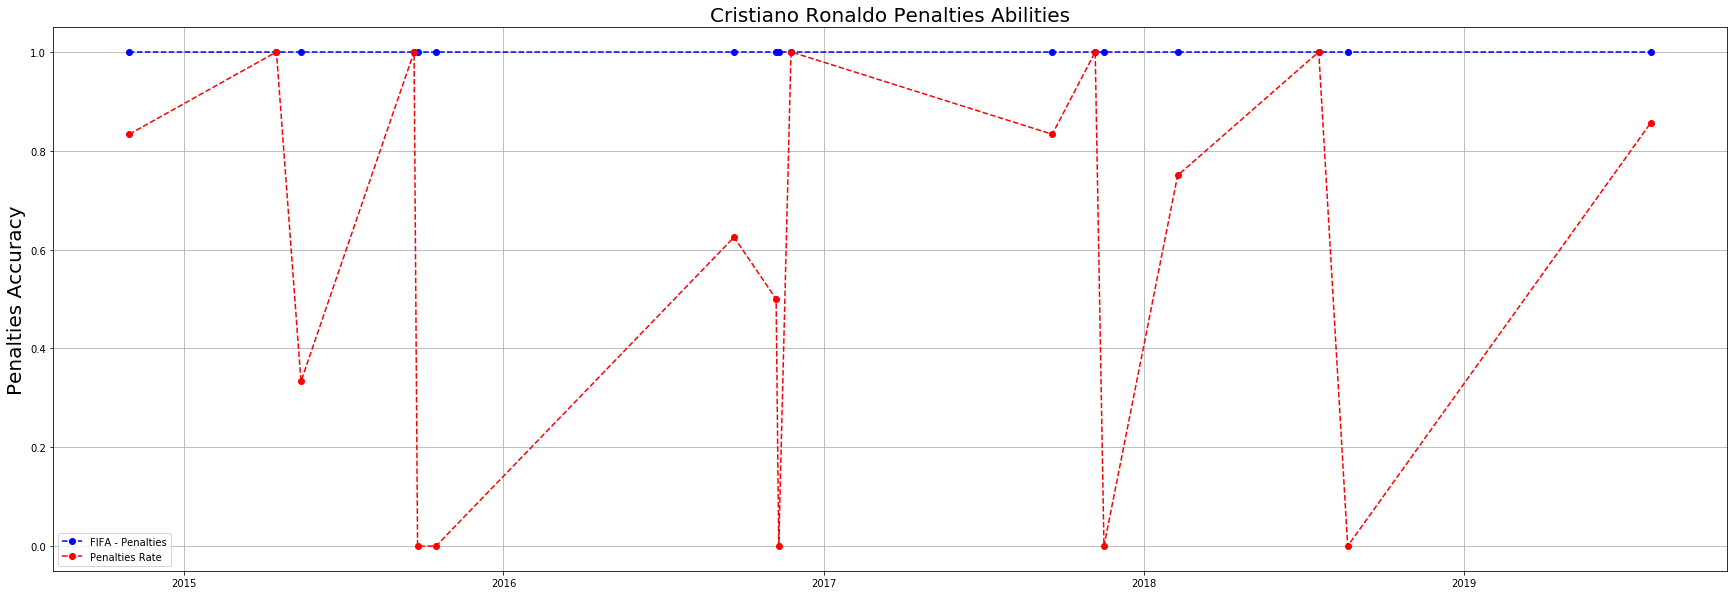

In [43]:
x, y1 = zip(*sorted(zip(dates, rates)))
x, y2 = zip(*sorted(zip(dates, penalties)))

fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(111)

y2 = list(map(lambda x: x/max(y2), y2))

ax.plot_date(x=x, y=y2, marker = 'o', linestyle='--', color = 'blue', label = 'FIFA - Penalties')
ax.plot_date(x=x, y=y1, marker = 'o', linestyle='--', color = 'red', label = 'Penalties Rate')
plt.ylabel("Penalties Accuracy", fontsize=20)
plt.legend()
plt.title("Cristiano Ronaldo Penalties Abilities", fontsize=20)
plt.grid(True)

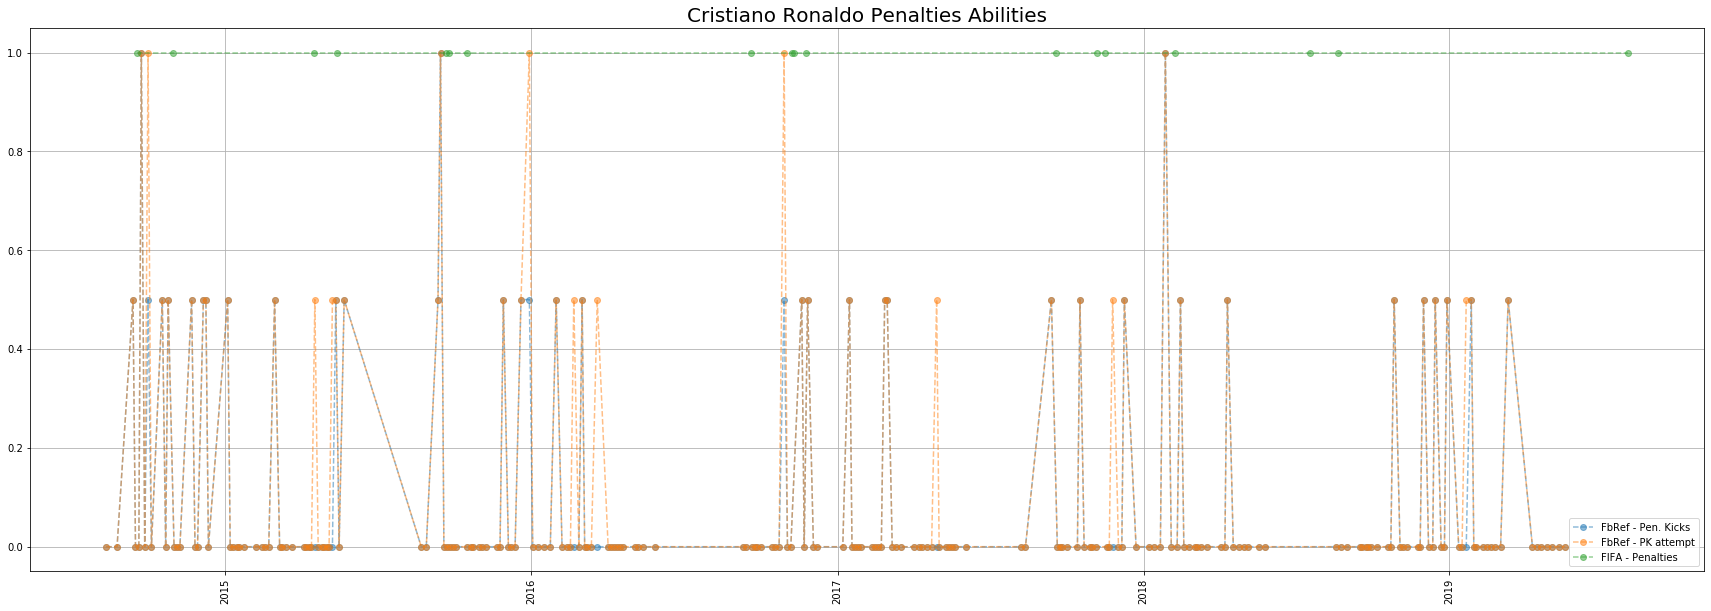

In [34]:
fb_features = ['Pen. Kicks', 'PK attempt']
fifa_features = ['Penalties']
temporal_analysis(df_fb, df_fifa, fb_features, fifa_features, 'Penalties Abilities')

#### Overall and Popularity Features

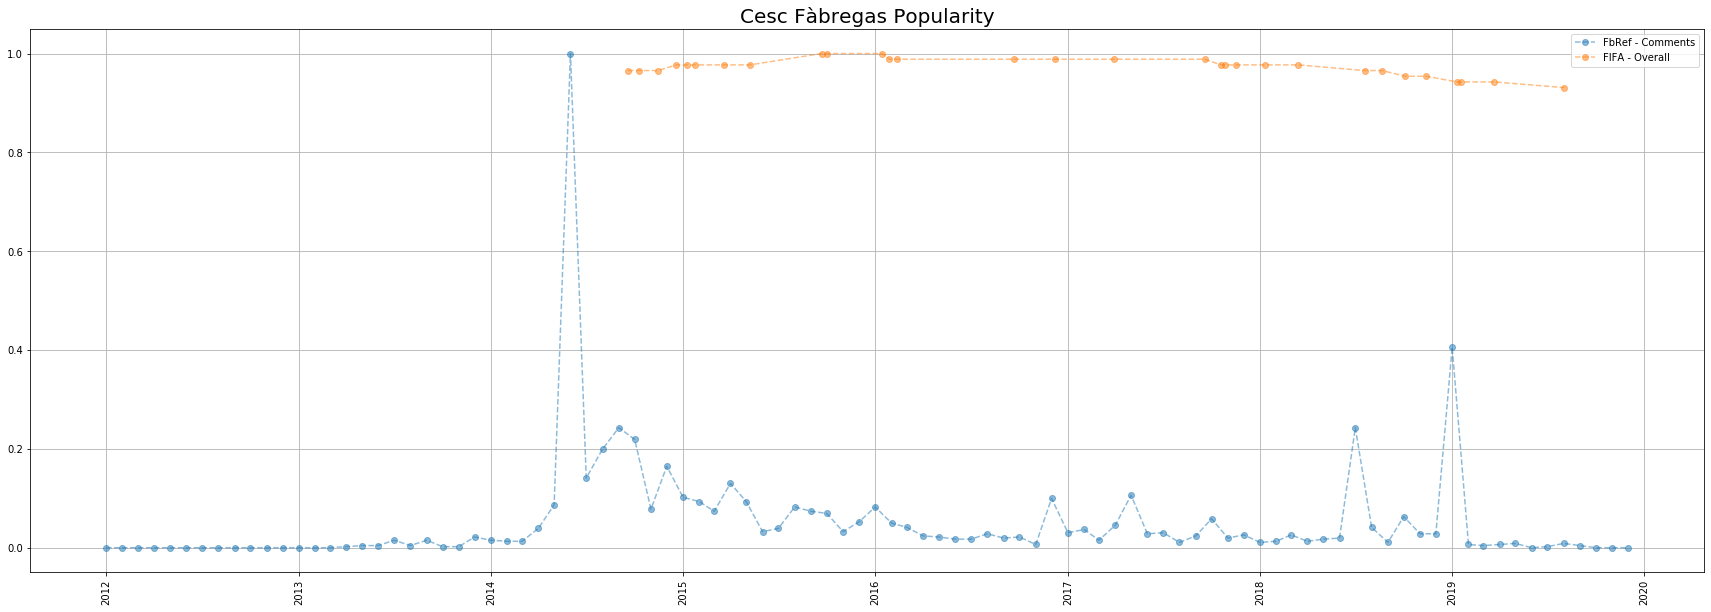

In [540]:
fb_features = ['Comments']
fifa_features = ['Overall']
temporal_analysis(df_comments, df_fifa, fb_features, fifa_features, 'Popularity')

In [ ]:
fb_features = ['Sentiment']
fifa_features = ['Overall']
temporal_analysis(df_temporal_sentiment, df_fifa, fb_features, fifa_features, 'Popularity',
                  analysis_type = 'Sentiment')

#### Shooting abilities

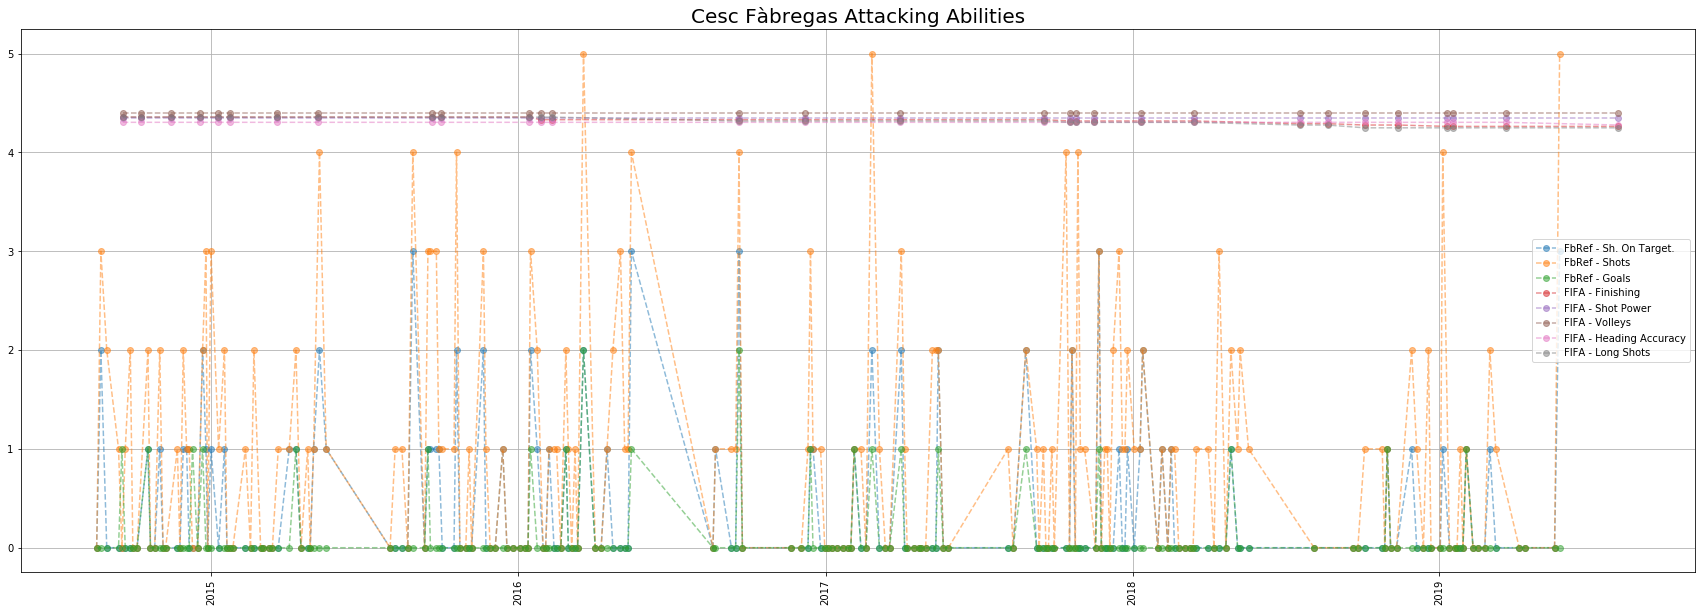

In [104]:
fb_features = ['Sh. On Target.', 'Shots', 'Goals']
fifa_features = ['Finishing', 'Shot Power', 'Volleys', 'Heading Accuracy',
                 'Long Shots']
temporal_analysis(df_fb, df_fifa, fb_features, fifa_features, 'Attacking Abilities')

#### Crossing and Assisting abilities

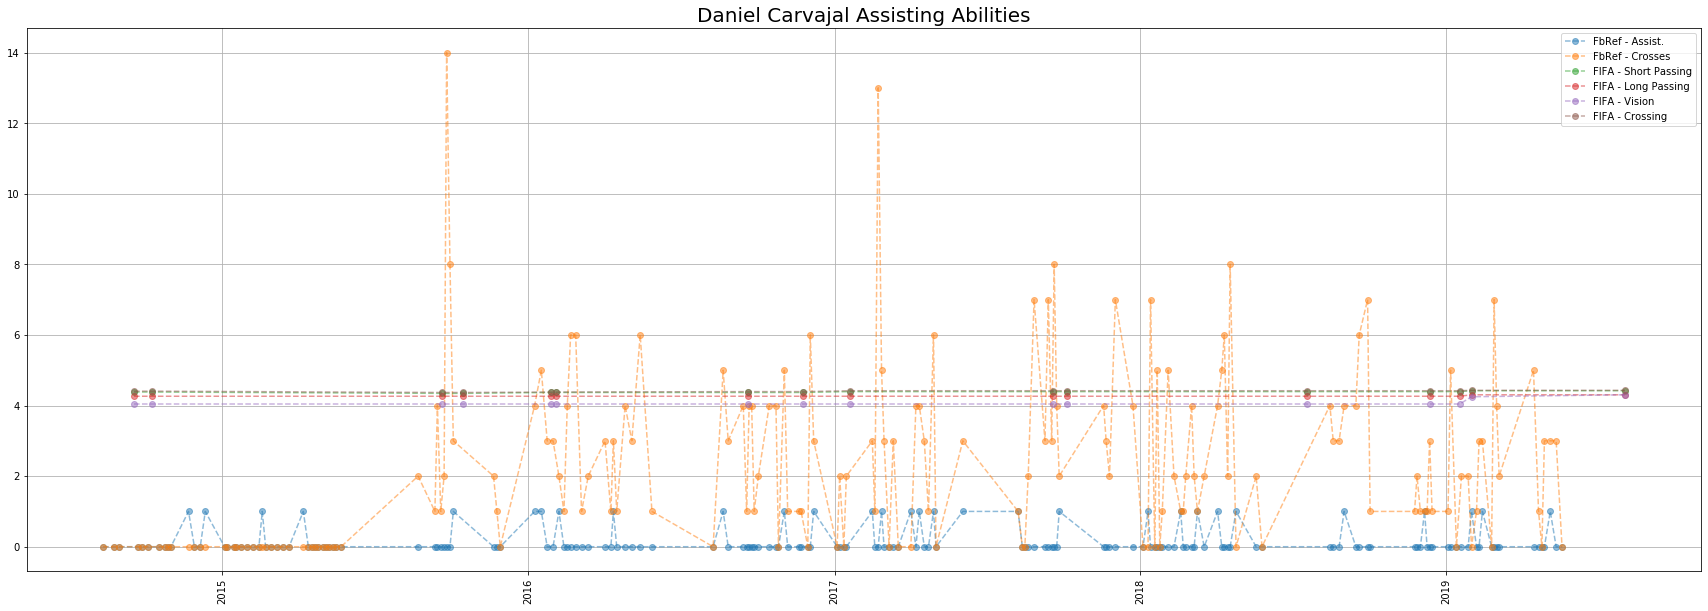

In [8]:
fb_features = ['Assist.', 'Crosses']
fifa_features = ['Short Passing', 'Long Passing', 'Vision', 'Crossing']
temporal_analysis(df_fb, df_fifa, fb_features, fifa_features, 'Assisting Abilities')

#### Defense abilities

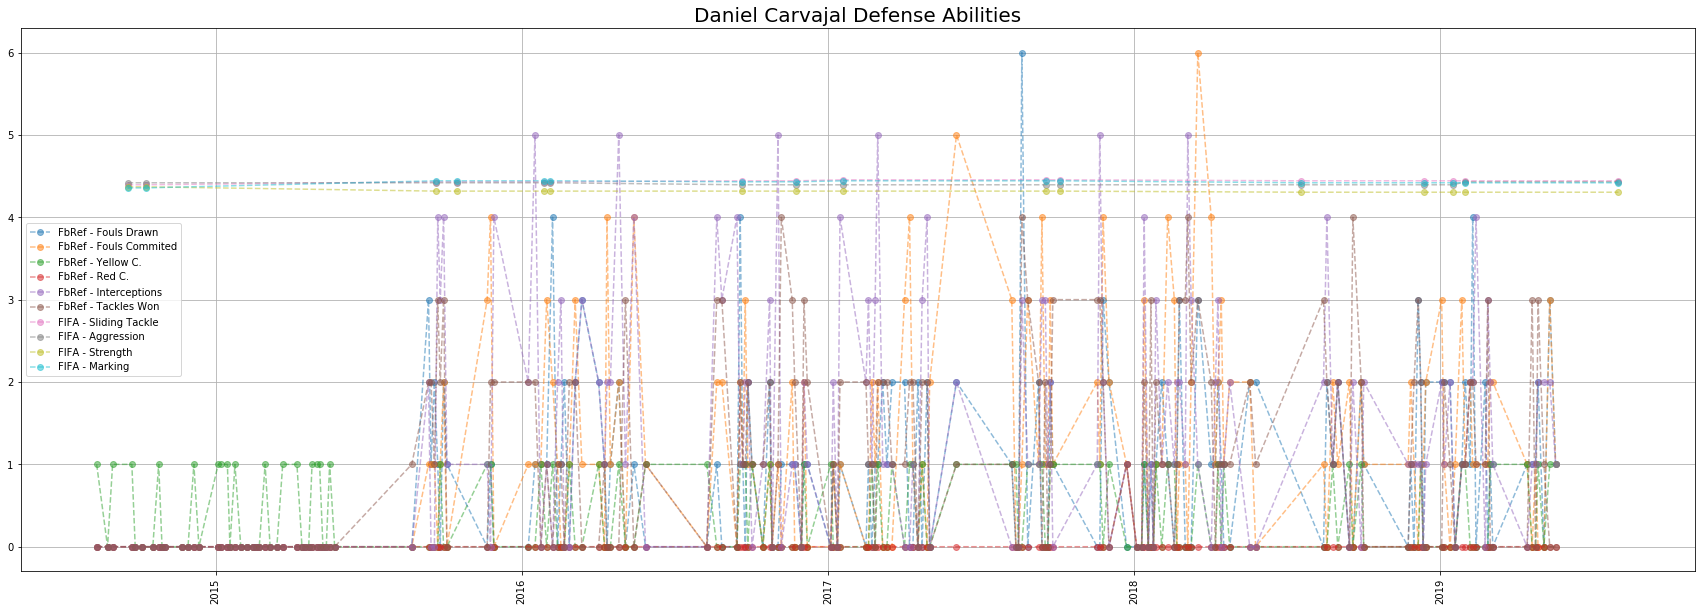

In [10]:
#fb_features = ['Tackles Won']
fb_features = ['Fouls Drawn', 'Fouls Commited', 'Yellow C.', 'Red C.',
               'Interceptions', 'Tackles Won']
fifa_features = ['Sliding Tackle', 'Aggression', 'Strength', 'Marking']
temporal_analysis(df_fb, df_fifa, fb_features, fifa_features, 'Defense Abilities')

#### Goalkeeper abilities

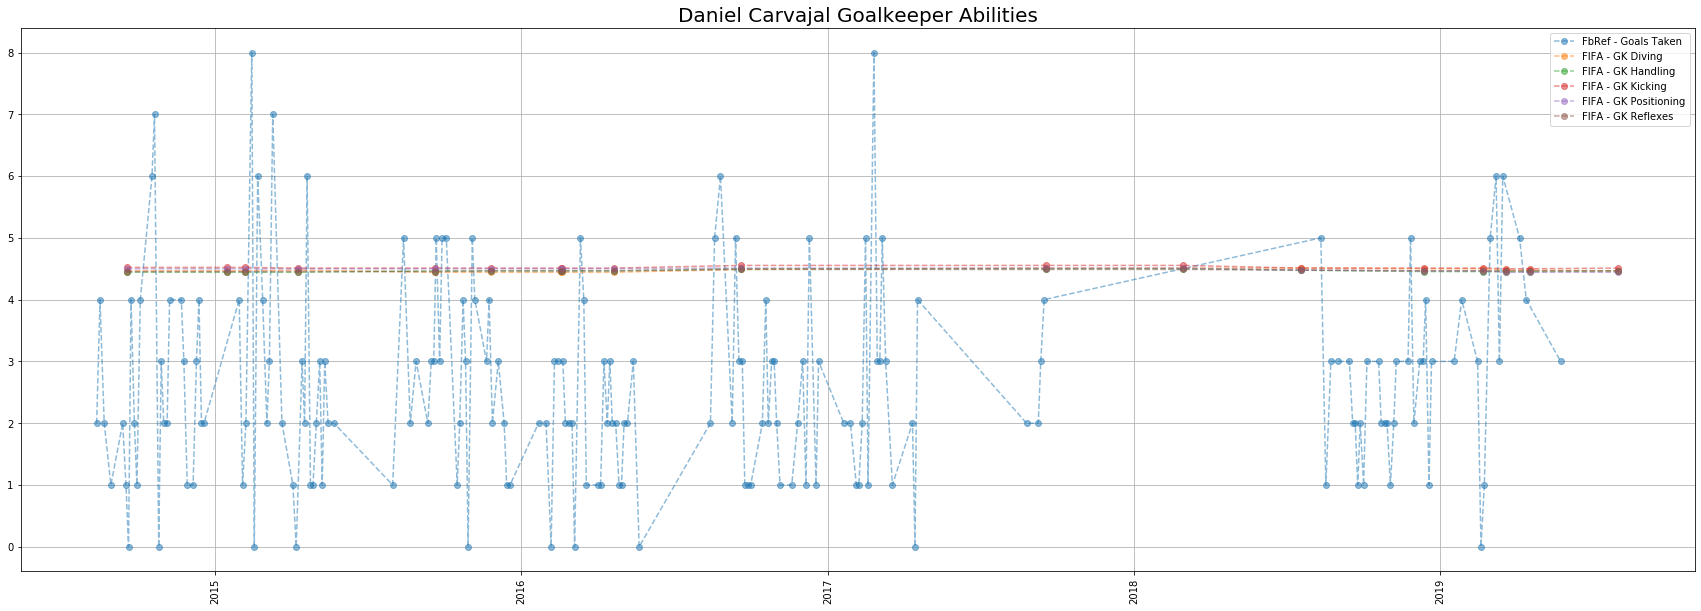

In [27]:
df_fb['Goals Taken'] = list(map(lambda x: goals_taken(x), df_fb['Result']))
fb_features = ['Goals Taken']
fifa_features = ['GK Diving', 'GK Handling', 'GK Kicking', 'GK Positioning', 'GK Reflexes']
temporal_analysis(df_fb, df_fifa, fb_features, fifa_features, 'Goalkeeper Abilities')

#### Future Works:

- Correlation Heatmap
- Amount of comments
- Topic Modeling
- Presentation
- Paper

Text(0, 0.5, 'Amount of Papers')

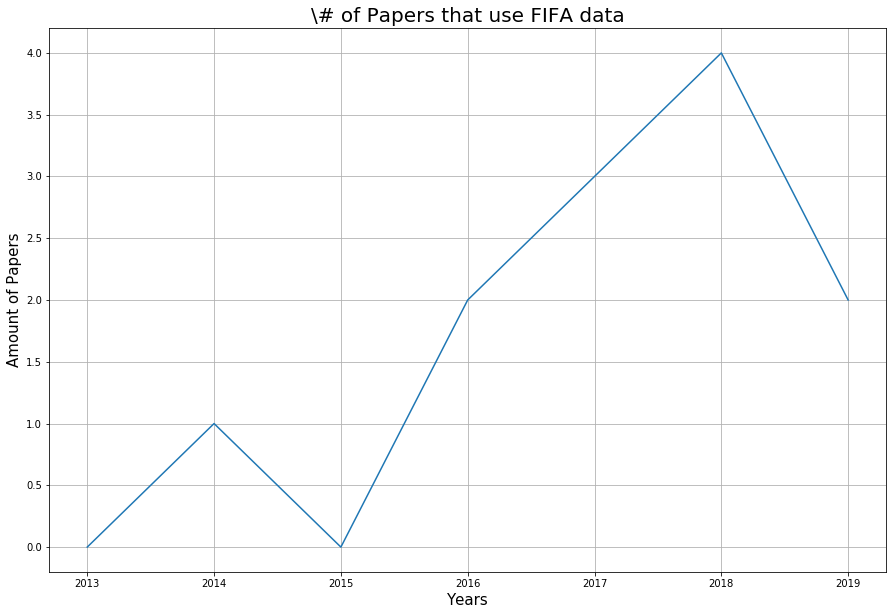

In [557]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
    
years_list = [2013, 2014, 2015, 2016, 2017, 2018, 2019]
papers_list = [0, 1, 0, 2, 3, 4, 2]

plt.plot(years_list, papers_list)
plt.grid(True)
plt.title("\# of Papers that use FIFA data", fontsize=20)
plt.xlabel("Years", fontsize=15)
plt.ylabel("Amount of Papers", fontsize=15)

In [3]:
df_corr = pd.read_table("Datasets/corr_matrix.txt", sep='\t')

### Correlation Analysis: Goalkeeper

In [ ]:
def make_corr_matrix(df):

    features_one = set(df['Feature One'])
    features_two = set(df['Feature Two'])

    for one in features_one:
        for two in features_two:
            pass

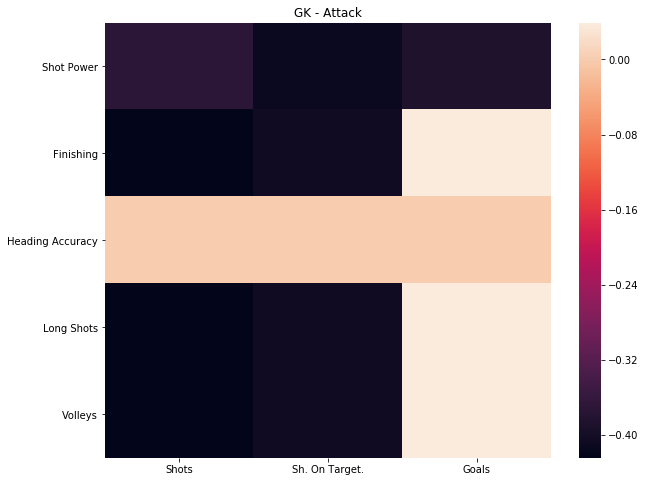

In [165]:
import time

plt.figure(figsize=(10, 8))

df_aux = df_corr.loc[(df_corr['Feature Set'] ==  'Attack')]
positions = ['GK']

for position in positions:
    
    df_position = df_aux.loc[df_aux['Position'] == position]
    #print(df_position.head(5))
    
    features_one = set(df_position['Feature One'])
    features_two = set(df_position['Feature Two'])
    matrix = []
    
    for one in features_one:
        corr = []
        for two in features_two:
            df = df_position.loc[(df_position['Feature One'] == one) & (df_position['Feature Two'] == two)]
            corr.append(df['Correlation'].values[0])
        matrix.append(corr)

    sns.heatmap(matrix, xticklabels = features_two, yticklabels = features_one)
    plt.title(position + ' - ' + df_position['Feature Set'].values[0])
    
    break

In [158]:
positions

{'CAM',
 'CB',
 'CDM',
 'CF',
 'CM',
 'GK',
 'LAM',
 'LB',
 'LCB',
 'LCM',
 'LDM',
 'LF',
 'LM',
 'LS',
 'LW',
 'RAM',
 'RB',
 'RCB',
 'RCM',
 'RDM',
 'RES',
 'RM',
 'RS',
 'RW',
 'ST',
 'SUB'}

In [68]:
positive = list(filter(lambda x: x>= 0.3, sorted(df_corr['Correlation'].values, reverse=True)))
negative = list(filter(lambda x: x<= -0.3, sorted(df_corr['Correlation'].values, reverse=True)))

In [76]:
for value in positive:
    print(df_corr.loc[df_corr['Correlation'] == value]['Feature One'].values[0],
          df_corr.loc[df_corr['Correlation'] == value]['Feature Two'].values[0],
          df_corr.loc[df_corr['Correlation'] == value]['Position'].values[0], value)

Shot Power Goals LB 0.8735623164745916
Heading Accuracy Shots LB 0.727223425104675
Heading Accuracy Sh. On Target. LB 0.7232508250544909
Crossing Crosses LB 0.7038281455719012
Marking Red C. RCB 0.6731080607655991
Strength Fouls Drawn LB 0.6667962952529201
Strength Fouls Commited LB 0.6175528820061692
Marking Red C. RAM 0.5434350988544511
Marking Yellow C. RCB 0.5224039454063112
Vision Crosses GK 0.4891404778524688
Sliding Tackle Interceptions LB 0.4774173109960306
Vision Crosses LB 0.4690460218302143
Sliding Tackle Tackles Won LB 0.4429239600557528
Sliding Tackle Red C. RAM 0.43368333057897396
Short Passing Crosses LB 0.43135925530151054
Shot Power Shots RCB 0.4260623951975195
Marking Fouls Commited RCB 0.4252699517782286
Long Shots Shots LB 0.423711368814077
Marking Fouls Commited RAM 0.4173414592957533
Long Shots Sh. On Target. LB 0.4134138371046386
Sliding Tackle Fouls Drawn LCB 0.40076912338364734
Strength Red C. CDM 0.3869954363263752
Strength Fouls Drawn RCB 0.38009979475605293


In [77]:
for value in negative:
    print(df_corr.loc[df_corr['Correlation'] == value]['Feature One'].values[0],
          df_corr.loc[df_corr['Correlation'] == value]['Feature Two'].values[0],
          df_corr.loc[df_corr['Correlation'] == value]['Position'].values[0], value)

Sliding Tackle Red C. LB -0.3043596980604562
Sliding Tackle Tackles Won LCM -0.30451851592835616
Sliding Tackle Fouls Commited GK -0.3046140478947306
Sliding Tackle Fouls Drawn GK -0.31649533247720296
Shot Power Goals RB -0.3271721778595733
Aggression Interceptions RB -0.3422234371397433
Strength Tackles Won RAM -0.3597288918986071
Sliding Tackle Interceptions LDM -0.3619013068727757
Strength Interceptions CDM -0.3667117632961544
Sliding Tackle Interceptions GK -0.3669142390407083
Short Passing Assist. RAM -0.3678577641958392
Shot Power Shots GK -0.37117101880603204
Vision Assist. RCB -0.38050514266899255
Sliding Tackle Yellow C. LB -0.38205504203011453
Strength Fouls Drawn LDM -0.3865633224816011
Sliding Tackle Yellow C. LDM -0.3865751055156695
Shot Power Goals GK -0.3873971042947868
Aggression Red C. LB -0.3935078313171644
Volleys Sh. On Target. GK -0.40571280273269533
Finishing Sh. On Target. GK -0.4057128027326954
Long Shots Sh. On Target. GK -0.4057128027326955
Shot Power Sh. On T

In [79]:
100 * (len(positive)/len(df_corr)), 100 * (len(negative)/len(df_corr))

(3.292181069958848, 3.4979423868312756)

In [ ]:
fifa_column = 'Overall'
two_column = 'Sentiment'
positions = set(df_fifa['Position'])
correlations = []
for position in positions:
    
    corr = correlation_analysis(df_fifa.loc[df_fifa['Position'] == position], df_temporal_sentiment,
                         fifa_column, two_column)

    correlations.append(corr)

Text(0.5, 1.0, 'Correlation Between the Sentiment and Overall')

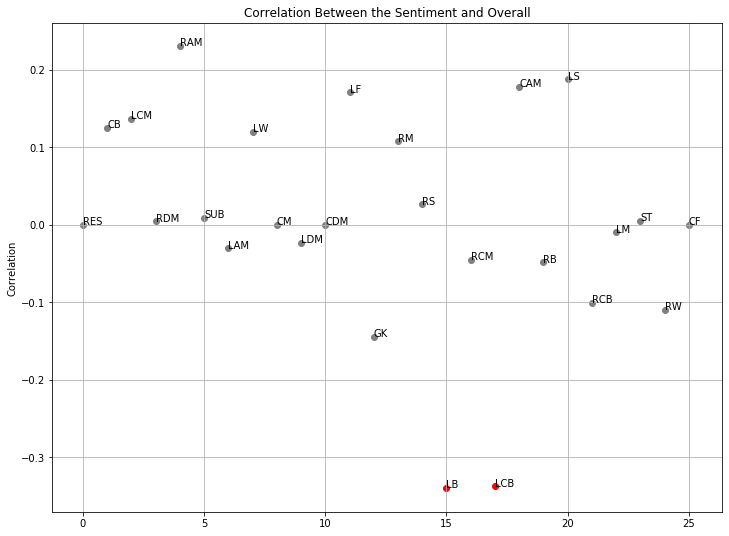

In [153]:
fig, ax = plt.subplots(figsize=(12, 9))
x = [i for i in range(0, len(correlations))]

for x_value, corr, label in zip(x, correlations, positions):
    
    
    
    if corr > -0.3 and corr < 0.3:
        plt.scatter(x_value, corr, color='grey')
    else:
        plt.scatter(x_value, corr, color='red')
    
    ax.annotate(label, (x_value, corr))
    
plt.grid(True)
plt.ylabel("Correlation")
plt.title("Correlation Between the Sentiment and Overall")

In [154]:
fifa_column, two_column = 'Overall', 'Comments'
correlations = []

for position in positions:
    corr = correlation_analysis(df_fifa.loc[df_fifa['Position'] == position],
                                df_comments, fifa_column, two_column)
    correlations.append(corr)

/usr/lib/python3.7/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/usr/lib/python3.7/site-packages/scipy/stats/stats.py:3005: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/usr/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/lib/python3.7/site-packages/scipy/stats/stats.py:3006: RuntimeWarning: Mean of empty slice.
  my = y.mean()


Text(0.5, 1.0, 'Correlation Between the Comments and Overall')

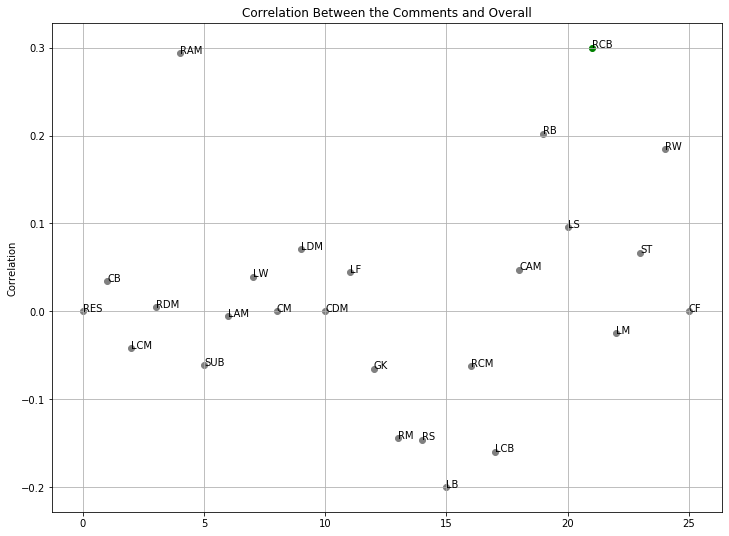

In [157]:
fig, ax = plt.subplots(figsize=(12, 9))
x = [i for i in range(0, len(correlations))]

for x_value, corr, label in zip(x, correlations, positions):
    
    
    
    if corr > -0.3 and corr < 0.3:
        plt.scatter(x_value, corr, color='grey')
    else:
        plt.scatter(x_value, corr, color='green')
    
    ax.annotate(label, (x_value, corr))
    
plt.grid(True)
plt.ylabel("Correlation")
plt.title("Correlation Between the Comments and Overall")